## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/solubility/solub_klek_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_klek_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_klek_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train_all = df_train_all['solubility']

X_train = df_train.loc[:, df_train.columns != 'solubility']
y_train = df_train['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

X_valid = df_valid.loc[:, df_valid.columns != 'solubility']
y_valid = df_valid['solubility']

In [5]:
with open('../../klek_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['solubility']]
X_train = X_train[idxs['solubility']]
X_test = X_test[idxs['solubility']]
X_valid = X_valid[idxs['solubility']]

In [6]:
X_train.shape

(1234, 576)

In [7]:
X_test.shape

(353, 576)

In [8]:
X_valid.shape

(176, 576)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [34]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(576, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [30]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [35]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=176, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 4.546008611336733, Accuracy: -4.021395818565728
Test Avg. loss: 6.842015743255615, Accuracy: -7.47681623965415
################## EPOCH 2 ##################
Train Avg. loss: 2.2115931113560996, Accuracy: -1.488043337014988
Test Avg. loss: 3.7317862510681152, Accuracy: -3.6234429249307807
################## EPOCH 3 ##################
Train Avg. loss: 2.1984147964379726, Accuracy: -1.4673262186199316
Test Avg. loss: 3.4794116020202637, Accuracy: -3.310766716313772
################## EPOCH 4 ##################
Train Avg. loss: 2.2903992304435143, Accuracy: -1.5588908134813748
Test Avg. loss: 4.376489162445068, Accuracy: -4.422188318827254
################## EPOCH 5 ##################
Train Avg. loss: 2.090412907111339, Accuracy: -1.350310828165134
Test Avg. loss: 1.7780653238296509, Accuracy: -1.2029083292459894
################## EPOCH 6 ##################
Train Avg. loss: 2.001589435797471, Acc

Train Avg. loss: 1.0950277990255601, Accuracy: -0.24709751464179086
Test Avg. loss: 1.0936223268508911, Accuracy: -0.35492762111135234
################## EPOCH 48 ##################
Train Avg. loss: 1.0952996091964917, Accuracy: -0.23427404100938667
Test Avg. loss: 1.319047212600708, Accuracy: -0.6342145345405041
################## EPOCH 49 ##################
Train Avg. loss: 1.0702392092117896, Accuracy: -0.20870000457873447
Test Avg. loss: 1.025323748588562, Accuracy: -0.27031000762344304
################## EPOCH 50 ##################
Train Avg. loss: 1.1156419286361108, Accuracy: -0.26545824747283747
Test Avg. loss: 1.049025297164917, Accuracy: -0.2996747677511953
################## EPOCH 51 ##################
Train Avg. loss: 0.9507894653540391, Accuracy: -0.08388878987455738
Test Avg. loss: 1.0545481443405151, Accuracy: -0.30651720160079154
################## EPOCH 52 ##################
Train Avg. loss: 1.059004225792029, Accuracy: -0.1892006194351048
Test Avg. loss: 0.96627646684

Train Avg. loss: 0.6066086101226318, Accuracy: 0.2998112172525175
Test Avg. loss: 0.9330847859382629, Accuracy: -0.1560319034861286
################## EPOCH 94 ##################
Train Avg. loss: 0.6413349975378085, Accuracy: 0.28611370931344154
Test Avg. loss: 0.9107666015625, Accuracy: -0.12838122531783158
################## EPOCH 95 ##################
Train Avg. loss: 0.6577758575097109, Accuracy: 0.2617447465386078
Test Avg. loss: 0.8726664781570435, Accuracy: -0.08117762193359201
################## EPOCH 96 ##################
Train Avg. loss: 0.5855683355759351, Accuracy: 0.3390050487955851
Test Avg. loss: 0.9350314140319824, Accuracy: -0.15844363529842487
################## EPOCH 97 ##################
Train Avg. loss: 0.5825410072620099, Accuracy: 0.33040180967787464
Test Avg. loss: 0.8362813591957092, Accuracy: -0.036098813561466825
################## EPOCH 98 ##################
Train Avg. loss: 0.6200782641386374, Accuracy: 0.2865400402422784
Test Avg. loss: 0.9088452458381653,

Train Avg. loss: 0.3838938799424049, Accuracy: 0.5674780451801598
Test Avg. loss: 0.7750766277313232, Accuracy: 0.03972996825115693
################## EPOCH 140 ##################
Train Avg. loss: 0.37844442824522656, Accuracy: 0.5715033794194964
Test Avg. loss: 0.7922139167785645, Accuracy: 0.018498067088593917
################## EPOCH 141 ##################
Train Avg. loss: 0.4201473593711853, Accuracy: 0.5272456039181993
Test Avg. loss: 0.809001088142395, Accuracy: -0.0023001554850481387
################## EPOCH 142 ##################
Train Avg. loss: 0.37873867306953823, Accuracy: 0.5690119076293271
Test Avg. loss: 0.8088193535804749, Accuracy: -0.002075074629005025
################## EPOCH 143 ##################
Train Avg. loss: 0.38214730490476656, Accuracy: 0.5656100650939871
Test Avg. loss: 0.8101901412010193, Accuracy: -0.0037733858695008227
################## EPOCH 144 ##################
Train Avg. loss: 0.3745907476315132, Accuracy: 0.5701679018871091
Test Avg. loss: 0.82464

Train Avg. loss: 0.2232640511714495, Accuracy: 0.7479743482823223
Test Avg. loss: 0.7433936595916748, Accuracy: 0.07898317934150412
################## EPOCH 186 ##################
Train Avg. loss: 0.25998038664842266, Accuracy: 0.7019902874800833
Test Avg. loss: 0.7304425835609436, Accuracy: 0.0950286982003824
################## EPOCH 187 ##################
Train Avg. loss: 0.23392982475268534, Accuracy: 0.740124353240393
Test Avg. loss: 0.7687755227088928, Accuracy: 0.04753661862828129
################## EPOCH 188 ##################
Train Avg. loss: 0.24460847026262528, Accuracy: 0.722990283968708
Test Avg. loss: 0.7421939969062805, Accuracy: 0.08046940363429589
################## EPOCH 189 ##################
Train Avg. loss: 0.22806919709994242, Accuracy: 0.743099511216655
Test Avg. loss: 0.7620889544487, Accuracy: 0.05582079692268149
################## EPOCH 190 ##################
Train Avg. loss: 0.22881783182040238, Accuracy: 0.7406230287421537
Test Avg. loss: 0.7631489634513855, 

Train Avg. loss: 0.1805952577254711, Accuracy: 0.7979139768142222
Test Avg. loss: 0.7597182393074036, Accuracy: 0.05875807169901248
################## EPOCH 232 ##################
Train Avg. loss: 0.18489708598607626, Accuracy: 0.7923505187324114
Test Avg. loss: 0.7391793131828308, Accuracy: 0.0842044972023458
################## EPOCH 233 ##################
Train Avg. loss: 0.1764140281921778, Accuracy: 0.8006594951769093
Test Avg. loss: 0.7216572761535645, Accuracy: 0.10591311487410326
################## EPOCH 234 ##################
Train Avg. loss: 0.18963337192932764, Accuracy: 0.7857802430679401
Test Avg. loss: 0.7446933388710022, Accuracy: 0.07737293187507832
################## EPOCH 235 ##################
Train Avg. loss: 0.16799760858217874, Accuracy: 0.8116456547994054
Test Avg. loss: 0.7192040681838989, Accuracy: 0.10895251985280163
################## EPOCH 236 ##################
Train Avg. loss: 0.18808896648578155, Accuracy: 0.7907905236442964
Test Avg. loss: 0.7543868422508

Train Avg. loss: 0.15531171686374223, Accuracy: 0.8257687111272657
Test Avg. loss: 0.7131316065788269, Accuracy: 0.11647592856432754
################## EPOCH 278 ##################
Train Avg. loss: 0.1540093066600653, Accuracy: 0.8253021356595732
Test Avg. loss: 0.6998452544212341, Accuracy: 0.1329367917554901
################## EPOCH 279 ##################
Train Avg. loss: 0.14991423716911903, Accuracy: 0.8338858020847452
Test Avg. loss: 0.7140185832977295, Accuracy: 0.11537700651727778
################## EPOCH 280 ##################
Train Avg. loss: 0.15398674057080194, Accuracy: 0.8273572247953944
Test Avg. loss: 0.7011602520942688, Accuracy: 0.13130751546580366
################## EPOCH 281 ##################
Train Avg. loss: 0.1474217101931572, Accuracy: 0.8348294020745141
Test Avg. loss: 0.7035223841667175, Accuracy: 0.12838113019925912
################## EPOCH 282 ##################
Train Avg. loss: 0.1487908539099571, Accuracy: 0.8326346592853096
Test Avg. loss: 0.74878054857254

Train Avg. loss: 1.791824895143509, Accuracy: -0.9583221879537289
Test Avg. loss: 1.6477270126342773, Accuracy: -1.0414276648379452
################## EPOCH 25 ##################
Train Avg. loss: 1.8528866291046142, Accuracy: -1.01962087981121
Test Avg. loss: 1.704525351524353, Accuracy: -1.1117971382523062
################## EPOCH 26 ##################
Train Avg. loss: 1.8586126506328582, Accuracy: -1.0363968242956738
Test Avg. loss: 2.0091447830200195, Accuracy: -1.4892008796423881
################## EPOCH 27 ##################
Train Avg. loss: 1.855509203672409, Accuracy: -0.9922044245936128
Test Avg. loss: 2.0302352905273438, Accuracy: -1.515330611107816
################## EPOCH 28 ##################
Train Avg. loss: 1.6294377475976944, Accuracy: -0.7789907144354136
Test Avg. loss: 1.8071517944335938, Accuracy: -1.2389447808429068
################## EPOCH 29 ##################
Train Avg. loss: 1.834410345554352, Accuracy: -1.0069595986280968
Test Avg. loss: 1.8023000955581665, Accu

Train Avg. loss: 1.2400029987096786, Accuracy: -0.34386515905173287
Test Avg. loss: 1.044721245765686, Accuracy: -0.29434232479639744
################## EPOCH 71 ##################
Train Avg. loss: 1.338020133972168, Accuracy: -0.4558317740678115
Test Avg. loss: 1.4615638256072998, Accuracy: -0.8107836879575476
################## EPOCH 72 ##################
Train Avg. loss: 1.2085258334875106, Accuracy: -0.30907547542351016
Test Avg. loss: 1.4401715993881226, Accuracy: -0.784279905473674
################## EPOCH 73 ##################
Train Avg. loss: 1.2127122223377227, Accuracy: -0.3051843117837049
Test Avg. loss: 1.2215598821640015, Accuracy: -0.5134340213193882
################## EPOCH 74 ##################
Train Avg. loss: 1.3632277190685271, Accuracy: -0.4908415807314889
Test Avg. loss: 1.2772705554962158, Accuracy: -0.5824559097850639
################## EPOCH 75 ##################
Train Avg. loss: 1.2140801578760148, Accuracy: -0.33302807173938326
Test Avg. loss: 1.55162227153778

Train Avg. loss: 0.9816043674945831, Accuracy: -0.06109080684124764
Test Avg. loss: 1.0696983337402344, Accuracy: -0.32528741821649
################## EPOCH 117 ##################
Train Avg. loss: 0.8971975266933441, Accuracy: 0.029137427944701304
Test Avg. loss: 0.9313229918479919, Accuracy: -0.15384917816893107
################## EPOCH 118 ##################
Train Avg. loss: 0.8923872441053391, Accuracy: 0.03930172830847116
Test Avg. loss: 1.002802848815918, Accuracy: -0.24240817478610976
################## EPOCH 119 ##################
Train Avg. loss: 0.9336365282535553, Accuracy: -0.01603764499237098
Test Avg. loss: 1.0080007314682007, Accuracy: -0.24884796369079853
################## EPOCH 120 ##################
Train Avg. loss: 0.8611464321613311, Accuracy: 0.07040059805734301
Test Avg. loss: 1.1268630027770996, Accuracy: -0.3961105505479592
################## EPOCH 121 ##################
Train Avg. loss: 0.9038454085588455, Accuracy: 0.021373433723957815
Test Avg. loss: 0.984788

Train Avg. loss: 0.653231343626976, Accuracy: 0.29285986140677334
Test Avg. loss: 0.9418818950653076, Accuracy: -0.16693103056372327
################## EPOCH 163 ##################
Train Avg. loss: 0.6860455006361008, Accuracy: 0.25482537053162563
Test Avg. loss: 0.8912740349769592, Accuracy: -0.10423112969630943
################## EPOCH 164 ##################
Train Avg. loss: 0.6332210898399353, Accuracy: 0.31288562087637706
Test Avg. loss: 0.8763757348060608, Accuracy: -0.0857731457862545
################## EPOCH 165 ##################
Train Avg. loss: 0.682521203160286, Accuracy: 0.2594323667428032
Test Avg. loss: 0.8670327067375183, Accuracy: -0.0741976913996476
################## EPOCH 166 ##################
Train Avg. loss: 0.6507849425077439, Accuracy: 0.3027251493166375
Test Avg. loss: 0.9093021154403687, Accuracy: -0.1265667937107804
################## EPOCH 167 ##################
Train Avg. loss: 0.594405323266983, Accuracy: 0.35928325126186456
Test Avg. loss: 0.8458852767944

Train Avg. loss: 0.46663340330123904, Accuracy: 0.49826699085011084
Test Avg. loss: 0.8480843305587769, Accuracy: -0.05072179682075939
################## EPOCH 210 ##################
Train Avg. loss: 0.46071843802928925, Accuracy: 0.499571525893983
Test Avg. loss: 0.8383376598358154, Accuracy: -0.03864631618893055
################## EPOCH 211 ##################
Train Avg. loss: 0.46929714530706407, Accuracy: 0.48825532689695655
Test Avg. loss: 0.8185950517654419, Accuracy: -0.014186556097833813
################## EPOCH 212 ##################
Train Avg. loss: 0.4779599353671074, Accuracy: 0.4823691636645903
Test Avg. loss: 0.789810836315155, Accuracy: 0.021475270052000894
################## EPOCH 213 ##################
Train Avg. loss: 0.48670655488967896, Accuracy: 0.4703803063337163
Test Avg. loss: 0.79132080078125, Accuracy: 0.01960445240620512
################## EPOCH 214 ##################
Train Avg. loss: 0.4608295030891895, Accuracy: 0.499625563080311
Test Avg. loss: 0.8774651288

Train Avg. loss: 0.3583074979484081, Accuracy: 0.613495179398409
Test Avg. loss: 0.7753804922103882, Accuracy: 0.03935352552164484
################## EPOCH 256 ##################
Train Avg. loss: 0.3717662990093231, Accuracy: 0.5942305007726403
Test Avg. loss: 0.7788338661193848, Accuracy: 0.03507505315639714
################## EPOCH 257 ##################
Train Avg. loss: 0.32873608618974687, Accuracy: 0.6442490666727927
Test Avg. loss: 0.7915469408035278, Accuracy: 0.01932442132625911
################## EPOCH 258 ##################
Train Avg. loss: 0.2964493528008461, Accuracy: 0.6781612689091391
Test Avg. loss: 0.8032644391059875, Accuracy: 0.004806995244724943
################## EPOCH 259 ##################
Train Avg. loss: 0.34220169112086296, Accuracy: 0.6243481380819992
Test Avg. loss: 0.767504096031189, Accuracy: 0.049111863373178744
################## EPOCH 260 ##################
Train Avg. loss: 0.354661750793457, Accuracy: 0.6181042030331588
Test Avg. loss: 0.761785805225372

Train Avg. loss: 8.369771766662598, Accuracy: -7.625608114915655
Test Avg. loss: 12.305142402648926, Accuracy: -14.245279055968942
################## EPOCH 2 ##################
Train Avg. loss: 3.00740704536438, Accuracy: -2.1784683983590396
Test Avg. loss: 7.655905723571777, Accuracy: -8.48517372222393
################## EPOCH 3 ##################
Train Avg. loss: 2.3061975717544554, Accuracy: -1.4446575313839816
Test Avg. loss: 5.3484272956848145, Accuracy: -5.6263569550424775
################## EPOCH 4 ##################
Train Avg. loss: 2.0280294179916383, Accuracy: -1.1461365148815637
Test Avg. loss: 3.939448833465576, Accuracy: -3.880722997694697
################## EPOCH 5 ##################
Train Avg. loss: 2.000656342506409, Accuracy: -1.0954999847047326
Test Avg. loss: 4.020714282989502, Accuracy: -3.981406272208649
################## EPOCH 6 ##################
Train Avg. loss: 1.919696295261383, Accuracy: -1.0299343045445652
Test Avg. loss: 2.759247064590454, Accuracy: -2.418

Train Avg. loss: 1.2883583784103394, Accuracy: -0.3602832644509782
Test Avg. loss: 1.3842893838882446, Accuracy: -0.7150454521256779
################## EPOCH 48 ##################
Train Avg. loss: 1.3393484115600587, Accuracy: -0.4162174435156543
Test Avg. loss: 2.2345235347747803, Accuracy: -1.7684304769941481
################## EPOCH 49 ##################
Train Avg. loss: 1.3831863760948182, Accuracy: -0.4576382332866472
Test Avg. loss: 1.511256217956543, Accuracy: -0.8723492601801994
################## EPOCH 50 ##################
Train Avg. loss: 1.2970136761665345, Accuracy: -0.37340200224613457
Test Avg. loss: 2.395066738128662, Accuracy: -1.9673333203710173
################## EPOCH 51 ##################
Train Avg. loss: 1.4284003138542176, Accuracy: -0.5105751816914932
Test Avg. loss: 2.349760055541992, Accuracy: -1.9112013483527135
################## EPOCH 52 ##################
Train Avg. loss: 1.4023703336715698, Accuracy: -0.479927338618816
Test Avg. loss: 2.1946754455566406, 

Train Avg. loss: 1.0445576369762422, Accuracy: -0.10583379784012985
Test Avg. loss: 1.4095665216445923, Accuracy: -0.7463620385658947
################## EPOCH 96 ##################
Train Avg. loss: 1.15877685546875, Accuracy: -0.22908815998703128
Test Avg. loss: 1.3223391771316528, Accuracy: -0.6382931467825432
################## EPOCH 97 ##################
Train Avg. loss: 1.1710580229759215, Accuracy: -0.23371912658555255
Test Avg. loss: 1.3534687757492065, Accuracy: -0.6768605508683856
################## EPOCH 98 ##################
Train Avg. loss: 1.0803589999675751, Accuracy: -0.13717128597004158
Test Avg. loss: 1.3520500659942627, Accuracy: -0.675102935039017
################## EPOCH 99 ##################
Train Avg. loss: 1.2117740750312804, Accuracy: -0.27189449992465387
Test Avg. loss: 1.1135215759277344, Accuracy: -0.37958157523523317
################## EPOCH 100 ##################
Train Avg. loss: 1.1766360521316528, Accuracy: -0.2373030061280507
Test Avg. loss: 1.24430751800

Train Avg. loss: 1.0023766160011292, Accuracy: -0.05609265788925695
Test Avg. loss: 1.2638856172561646, Accuracy: -0.5658727464680764
################## EPOCH 142 ##################
Train Avg. loss: 1.0283858060836792, Accuracy: -0.0834084700449821
Test Avg. loss: 1.2292734384536743, Accuracy: -0.5229905271398105
################## EPOCH 143 ##################
Train Avg. loss: 0.9188695013523102, Accuracy: 0.02445533665751822
Test Avg. loss: 1.1419847011566162, Accuracy: -0.4148454781003261
################## EPOCH 144 ##################
Train Avg. loss: 0.9035310447216034, Accuracy: 0.043022005964401255
Test Avg. loss: 1.4576586484909058, Accuracy: -0.8059451796956054
################## EPOCH 145 ##################
Train Avg. loss: 0.9357206463813782, Accuracy: 0.012561236313971668
Test Avg. loss: 1.3178154230117798, Accuracy: -0.6326886178488105
################## EPOCH 146 ##################
Train Avg. loss: 0.857097965478897, Accuracy: 0.09597455666965778
Test Avg. loss: 1.22024405

Train Avg. loss: 0.8061853170394897, Accuracy: 0.14500308495452302
Test Avg. loss: 1.0803537368774414, Accuracy: -0.33848862357490295
################## EPOCH 188 ##################
Train Avg. loss: 0.7625454902648926, Accuracy: 0.19427727029647132
Test Avg. loss: 1.1930186748504639, Accuracy: -0.47807341830720973
################## EPOCH 189 ##################
Train Avg. loss: 0.7676660239696502, Accuracy: 0.1898685660370138
Test Avg. loss: 1.2079483270645142, Accuracy: -0.4965701421638653
################## EPOCH 190 ##################
Train Avg. loss: 0.7363646447658538, Accuracy: 0.22374568497429084
Test Avg. loss: 1.282820463180542, Accuracy: -0.5893319298949176
################## EPOCH 191 ##################
Train Avg. loss: 0.7737845599651336, Accuracy: 0.18360737981404812
Test Avg. loss: 1.1445516347885132, Accuracy: -0.41802573438760793
################## EPOCH 192 ##################
Train Avg. loss: 0.7191647231578827, Accuracy: 0.24644344500547014
Test Avg. loss: 1.228660821

Train Avg. loss: 0.6570925176143646, Accuracy: 0.30756952667378756
Test Avg. loss: 1.115702748298645, Accuracy: -0.3822837921610407
################## EPOCH 234 ##################
Train Avg. loss: 0.6671508848667145, Accuracy: 0.2980567066250251
Test Avg. loss: 1.0362197160720825, Accuracy: -0.2838095369729068
################## EPOCH 235 ##################
Train Avg. loss: 0.6504174590110778, Accuracy: 0.31219130609028456
Test Avg. loss: 1.0808731317520142, Accuracy: -0.3391321215387779
################## EPOCH 236 ##################
Train Avg. loss: 0.7072841107845307, Accuracy: 0.2560998137018295
Test Avg. loss: 1.0736910104751587, Accuracy: -0.3302339121099289
################## EPOCH 237 ##################
Train Avg. loss: 0.6659152507781982, Accuracy: 0.2965177243537523
Test Avg. loss: 1.0482852458953857, Accuracy: -0.29875789345183157
################## EPOCH 238 ##################
Train Avg. loss: 0.6545137226581573, Accuracy: 0.30460205193268947
Test Avg. loss: 1.0375884771347

Train Avg. loss: 0.57356216609478, Accuracy: 0.3953428885439258
Test Avg. loss: 0.9620673656463623, Accuracy: -0.19193946751322866
################## EPOCH 281 ##################
Train Avg. loss: 0.5311885297298431, Accuracy: 0.436196973009762
Test Avg. loss: 0.9649162292480469, Accuracy: -0.1954690825229084
################## EPOCH 282 ##################
Train Avg. loss: 0.5724651455879212, Accuracy: 0.39477663289855414
Test Avg. loss: 0.9837936162948608, Accuracy: -0.21885689468781755
################## EPOCH 283 ##################
Train Avg. loss: 0.5689555257558823, Accuracy: 0.39974131244626593
Test Avg. loss: 1.0161371231079102, Accuracy: -0.2589284474492526
################## EPOCH 284 ##################
Train Avg. loss: 0.5281179487705231, Accuracy: 0.44329879329099686
Test Avg. loss: 0.9897405505180359, Accuracy: -0.22622485092525246
################## EPOCH 285 ##################
Train Avg. loss: 0.5354426294565201, Accuracy: 0.4350825723479357
Test Avg. loss: 0.9794197082519

Train Avg. loss: 1.2587410926818847, Accuracy: -0.32385158363979827
Test Avg. loss: 3.541551113128662, Accuracy: -3.3877536871196066
################## EPOCH 27 ##################
Train Avg. loss: 1.1466736316680908, Accuracy: -0.2006023057721163
Test Avg. loss: 3.176271677017212, Accuracy: -2.9351956698739494
################## EPOCH 28 ##################
Train Avg. loss: 1.2050599098205566, Accuracy: -0.2664874894105675
Test Avg. loss: 3.5666210651397705, Accuracy: -3.4188136370579274
################## EPOCH 29 ##################
Train Avg. loss: 1.2056503534317016, Accuracy: -0.2668778825611099
Test Avg. loss: 3.57432222366333, Accuracy: -3.428354849063111
################## EPOCH 30 ##################
Train Avg. loss: 1.1576810121536254, Accuracy: -0.21611745017943057
Test Avg. loss: 3.364037275314331, Accuracy: -3.167825567933475
################## EPOCH 31 ##################
Train Avg. loss: 1.1641178607940674, Accuracy: -0.220914592520967
Test Avg. loss: 3.337308883666992, Accu

Train Avg. loss: 1.0397246122360229, Accuracy: -0.08936549558599549
Test Avg. loss: 2.9432106018066406, Accuracy: -2.6464485032228517
################## EPOCH 73 ##################
Train Avg. loss: 1.0634865522384644, Accuracy: -0.1165472358182155
Test Avg. loss: 2.651090145111084, Accuracy: -2.2845299474428566
################## EPOCH 74 ##################
Train Avg. loss: 1.0481947660446167, Accuracy: -0.10164713319243131
Test Avg. loss: 2.8649673461914062, Accuracy: -2.5495099134966983
################## EPOCH 75 ##################
Train Avg. loss: 1.1003193378448486, Accuracy: -0.15816237506387226
Test Avg. loss: 2.507991075515747, Accuracy: -2.107239123924227
################## EPOCH 76 ##################
Train Avg. loss: 1.0528164625167846, Accuracy: -0.10583819603433757
Test Avg. loss: 2.6432971954345703, Accuracy: -2.274874794790742
################## EPOCH 77 ##################
Train Avg. loss: 1.0213909864425659, Accuracy: -0.07039175757922342
Test Avg. loss: 2.50092911720275

Train Avg. loss: 0.9669644713401795, Accuracy: -0.01544580783685574
Test Avg. loss: 2.347153425216675, Accuracy: -1.9079719728962892
################## EPOCH 123 ##################
Train Avg. loss: 0.9287248253822327, Accuracy: 0.025870074500010352
Test Avg. loss: 2.350912094116211, Accuracy: -1.9126285851898013
################## EPOCH 124 ##################
Train Avg. loss: 0.993327510356903, Accuracy: -0.042042322990469214
Test Avg. loss: 2.204444169998169, Accuracy: -1.7311645048288389
################## EPOCH 125 ##################
Train Avg. loss: 0.9313443779945374, Accuracy: 0.023871904776724805
Test Avg. loss: 2.0233707427978516, Accuracy: -1.5068258337506384
################## EPOCH 126 ##################
Train Avg. loss: 0.9055910229682922, Accuracy: 0.04874248312085181
Test Avg. loss: 2.0055935382843018, Accuracy: -1.4848011447596634
################## EPOCH 127 ##################
Train Avg. loss: 0.9060880064964294, Accuracy: 0.04713956043172045
Test Avg. loss: 2.195063591

Train Avg. loss: 0.8623602747917175, Accuracy: 0.09319834441234329
Test Avg. loss: 1.6204768419265747, Accuracy: -1.0076665273456284
################## EPOCH 169 ##################
Train Avg. loss: 0.8996907472610474, Accuracy: 0.054268265980953245
Test Avg. loss: 1.855548620223999, Accuracy: -1.2989052408333186
################## EPOCH 170 ##################
Train Avg. loss: 0.8561773180961609, Accuracy: 0.10246963807934424
Test Avg. loss: 1.6286718845367432, Accuracy: -1.0178196003057973
################## EPOCH 171 ##################
Train Avg. loss: 0.8710509657859802, Accuracy: 0.08837379203167497
Test Avg. loss: 1.8406168222427368, Accuracy: -1.2804055480496794
################## EPOCH 172 ##################
Train Avg. loss: 0.8374168157577515, Accuracy: 0.1218851534304128
Test Avg. loss: 1.61342453956604, Accuracy: -0.9989291846427084
################## EPOCH 173 ##################
Train Avg. loss: 0.8325358748435974, Accuracy: 0.12797450303346128
Test Avg. loss: 2.1332297325134

Train Avg. loss: 0.8109857439994812, Accuracy: 0.14902327409493138
Test Avg. loss: 1.3602501153945923, Accuracy: -0.6852622900310468
################## EPOCH 219 ##################
Train Avg. loss: 0.7766112208366394, Accuracy: 0.18342438589759402
Test Avg. loss: 1.5843058824539185, Accuracy: -0.9628527710383126
################## EPOCH 220 ##################
Train Avg. loss: 0.6969664812088012, Accuracy: 0.26776207267497865
Test Avg. loss: 1.491593837738037, Accuracy: -0.8479887176000713
################## EPOCH 221 ##################
Train Avg. loss: 0.7541532874107361, Accuracy: 0.2101810072166006
Test Avg. loss: 1.4850871562957764, Accuracy: -0.8399273466592614
################## EPOCH 222 ##################
Train Avg. loss: 0.8433556437492371, Accuracy: 0.11483703832631009
Test Avg. loss: 1.5230560302734375, Accuracy: -0.8869682789159428
################## EPOCH 223 ##################
Train Avg. loss: 0.7356558918952942, Accuracy: 0.23118667559164824
Test Avg. loss: 1.311586976051

Train Avg. loss: 0.7257828950881958, Accuracy: 0.23632433448016038
Test Avg. loss: 1.4494308233261108, Accuracy: -0.795751363522446
################## EPOCH 265 ##################
Train Avg. loss: 0.7191057562828064, Accuracy: 0.24484715487142966
Test Avg. loss: 1.261069416999817, Accuracy: -0.5623838422617893
################## EPOCH 266 ##################
Train Avg. loss: 0.6991647362709046, Accuracy: 0.2654232984437659
Test Avg. loss: 1.5326801538467407, Accuracy: -0.8988920193306131
################## EPOCH 267 ##################
Train Avg. loss: 0.7563337326049805, Accuracy: 0.20550247499312055
Test Avg. loss: 1.348308801651001, Accuracy: -0.6704676841739472
################## EPOCH 268 ##################
Train Avg. loss: 0.7172922611236572, Accuracy: 0.2473005887349605
Test Avg. loss: 1.5077719688415527, Accuracy: -0.8680324675398492
################## EPOCH 269 ##################
Train Avg. loss: 0.6852105379104614, Accuracy: 0.28342313159384236
Test Avg. loss: 1.498720169067382

Train Avg. loss: 1.7858076156714024, Accuracy: -0.9896215439283952
Test Avg. loss: 1.1013191938400269, Accuracy: -0.36446348238328286
################## EPOCH 11 ##################
Train Avg. loss: 1.6119343959368193, Accuracy: -0.8165611980939413
Test Avg. loss: 1.1254504919052124, Accuracy: -0.3943606877256096
################## EPOCH 12 ##################
Train Avg. loss: 1.6088516834454658, Accuracy: -0.8210604545411483
Test Avg. loss: 0.9308825731277466, Accuracy: -0.15330348521665327
################## EPOCH 13 ##################
Train Avg. loss: 1.4373112137501056, Accuracy: -0.6285064907257706
Test Avg. loss: 0.8197030425071716, Accuracy: -0.01555925783580947
################## EPOCH 14 ##################
Train Avg. loss: 1.5206856360802283, Accuracy: -0.6913453031130954
Test Avg. loss: 1.0049134492874146, Accuracy: -0.2450230245855909
################## EPOCH 15 ##################
Train Avg. loss: 1.418650501813644, Accuracy: -0.5551490584720213
Test Avg. loss: 0.9912948608398

Train Avg. loss: 0.38374229845328206, Accuracy: 0.5748923360693984
Test Avg. loss: 0.8326177597045898, Accuracy: -0.03155978873427112
################## EPOCH 57 ##################
Train Avg. loss: 0.3661451076085751, Accuracy: 0.5838883126467439
Test Avg. loss: 0.76539546251297, Accuracy: 0.051724304672629895
################## EPOCH 58 ##################
Train Avg. loss: 0.36985150094215685, Accuracy: 0.5867216608581948
Test Avg. loss: 0.7522342801094055, Accuracy: 0.06803011019215144
################## EPOCH 59 ##################
Train Avg. loss: 0.31862397759388655, Accuracy: 0.6384417850796433
Test Avg. loss: 0.8406316637992859, Accuracy: -0.0414884282904322
################## EPOCH 60 ##################
Train Avg. loss: 0.3584078875107643, Accuracy: 0.5960656269146806
Test Avg. loss: 0.7794782519340515, Accuracy: 0.034276627304520524
################## EPOCH 61 ##################
Train Avg. loss: 0.318617405799719, Accuracy: 0.640053122780685
Test Avg. loss: 0.7625014781951904, A

Train Avg. loss: 0.24406815339357424, Accuracy: 0.7283397131466336
Test Avg. loss: 0.7154139876365662, Accuracy: 0.11364817242456005
################## EPOCH 103 ##################
Train Avg. loss: 0.23707961424803123, Accuracy: 0.7330825910021858
Test Avg. loss: 0.7364957332611084, Accuracy: 0.08752927676819078
################## EPOCH 104 ##################
Train Avg. loss: 0.2396051967755342, Accuracy: 0.7327975984273706
Test Avg. loss: 0.7175958156585693, Accuracy: 0.1109450105962172
################## EPOCH 105 ##################
Train Avg. loss: 0.2241970296853628, Accuracy: 0.7480847583652201
Test Avg. loss: 0.6613594889640808, Accuracy: 0.1806182483124661
################## EPOCH 106 ##################
Train Avg. loss: 0.24810401980693525, Accuracy: 0.722190398675056
Test Avg. loss: 0.7454371452331543, Accuracy: 0.07645143074854566
################## EPOCH 107 ##################
Train Avg. loss: 0.2335028228087303, Accuracy: 0.742400431475964
Test Avg. loss: 0.7099299430847168,

Train Avg. loss: 0.2222258698863861, Accuracy: 0.7513244529974894
Test Avg. loss: 0.7234857678413391, Accuracy: 0.10364778764733384
################## EPOCH 149 ##################
Train Avg. loss: 0.21399037253398162, Accuracy: 0.761503245528575
Test Avg. loss: 0.7071487903594971, Accuracy: 0.12388819379012928
################## EPOCH 150 ##################
Train Avg. loss: 0.20884951834495252, Accuracy: 0.7679961756267216
Test Avg. loss: 0.6990873217582703, Accuracy: 0.13387582220851957
################## EPOCH 151 ##################
Train Avg. loss: 0.2200334521058278, Accuracy: 0.7576758443472491
Test Avg. loss: 0.6978452205657959, Accuracy: 0.13541472609568306
################## EPOCH 152 ##################
Train Avg. loss: 0.22476567480808649, Accuracy: 0.7458326684771037
Test Avg. loss: 0.7113217711448669, Accuracy: 0.11871817290446762
################## EPOCH 153 ##################
Train Avg. loss: 0.2223015525020086, Accuracy: 0.7484575254703737
Test Avg. loss: 0.75090444087982

Train Avg. loss: 0.20672580485160535, Accuracy: 0.7664328352720979
Test Avg. loss: 0.693594753742218, Accuracy: 0.1406807695271871
################## EPOCH 195 ##################
Train Avg. loss: 0.1834945180095159, Accuracy: 0.7956518147949724
Test Avg. loss: 0.741867184638977, Accuracy: 0.08087435758527772
################## EPOCH 196 ##################
Train Avg. loss: 0.20520253001879424, Accuracy: 0.7701037344672509
Test Avg. loss: 0.7442155480384827, Accuracy: 0.07796482315826381
################## EPOCH 197 ##################
Train Avg. loss: 0.18963296443988115, Accuracy: 0.7861424229542656
Test Avg. loss: 0.7216859459877014, Accuracy: 0.10587762256668198
################## EPOCH 198 ##################
Train Avg. loss: 0.19795670627783507, Accuracy: 0.7779782742412931
Test Avg. loss: 0.7486509084701538, Accuracy: 0.0724697151935777
################## EPOCH 199 ##################
Train Avg. loss: 0.19972105687245345, Accuracy: 0.7739290678367059
Test Avg. loss: 0.716071963310241

Train Avg. loss: 0.17047268725358522, Accuracy: 0.811751661822851
Test Avg. loss: 0.7225303053855896, Accuracy: 0.10483148178697388
################## EPOCH 241 ##################
Train Avg. loss: 0.17722401290367812, Accuracy: 0.8048008842225755
Test Avg. loss: 0.7438228726387024, Accuracy: 0.0784513999116464
################## EPOCH 242 ##################
Train Avg. loss: 0.17472865642645422, Accuracy: 0.8075571755339132
Test Avg. loss: 0.77862548828125, Accuracy: 0.035333176378868125
################## EPOCH 243 ##################
Train Avg. loss: 0.184478525358897, Accuracy: 0.7918139668916179
Test Avg. loss: 0.7489884495735168, Accuracy: 0.07205158201674411
################## EPOCH 244 ##################
Train Avg. loss: 0.1901081022925866, Accuracy: 0.7882320020584179
Test Avg. loss: 0.7604293823242188, Accuracy: 0.05787694039120317
################## EPOCH 245 ##################
Train Avg. loss: 0.1703676896599623, Accuracy: 0.8079206354026665
Test Avg. loss: 0.7165733575820923,

Train Avg. loss: 0.17183154630355346, Accuracy: 0.8078631152157051
Test Avg. loss: 0.791710376739502, Accuracy: 0.019121869796306035
################## EPOCH 287 ##################
Train Avg. loss: 0.15547352742690307, Accuracy: 0.8256706085677294
Test Avg. loss: 0.748271107673645, Accuracy: 0.07294034321664156
################## EPOCH 288 ##################
Train Avg. loss: 0.1638150772987268, Accuracy: 0.8108839753621137
Test Avg. loss: 0.7240347266197205, Accuracy: 0.1029676291875321
################## EPOCH 289 ##################
Train Avg. loss: 0.15768169573484322, Accuracy: 0.8249084260502153
Test Avg. loss: 0.7384786009788513, Accuracy: 0.0850726686686255
################## EPOCH 290 ##################
Train Avg. loss: 0.17622024241166237, Accuracy: 0.8047797330614506
Test Avg. loss: 0.7206849455833435, Accuracy: 0.10711779730202853
################## EPOCH 291 ##################
Train Avg. loss: 0.16917100185767198, Accuracy: 0.8078846197243208
Test Avg. loss: 0.73072212934494

Train Avg. loss: 1.060065081715584, Accuracy: -0.13695994963980498
Test Avg. loss: 0.8423742055892944, Accuracy: -0.043647463475780635
################## EPOCH 33 ##################
Train Avg. loss: 0.9712043613195419, Accuracy: -0.05583405213459834
Test Avg. loss: 0.8594359159469604, Accuracy: -0.06478565292788452
################## EPOCH 34 ##################
Train Avg. loss: 0.9638458520174027, Accuracy: -0.038145330106954964
Test Avg. loss: 0.8449925780296326, Accuracy: -0.04689124796700539
################## EPOCH 35 ##################
Train Avg. loss: 0.9609592169523239, Accuracy: -0.04168827410306265
Test Avg. loss: 0.7620736956596375, Accuracy: 0.05583973651362817
################## EPOCH 36 ##################
Train Avg. loss: 0.9271531790494919, Accuracy: -0.0037170981319306516
Test Avg. loss: 0.8633710145950317, Accuracy: -0.06966105228953512
################## EPOCH 37 ##################
Train Avg. loss: 0.9134103983640671, Accuracy: 0.016334576052888305
Test Avg. loss: 0.81

Train Avg. loss: 0.3864332139492035, Accuracy: 0.5783156609835542
Test Avg. loss: 0.7262349128723145, Accuracy: 0.10024165378173444
################## EPOCH 80 ##################
Train Avg. loss: 0.40816967859864234, Accuracy: 0.5522537520215303
Test Avg. loss: 0.7261290550231934, Accuracy: 0.10037295344672792
################## EPOCH 81 ##################
Train Avg. loss: 0.398820061981678, Accuracy: 0.5631925042910105
Test Avg. loss: 0.7496792674064636, Accuracy: 0.07119578352231604
################## EPOCH 82 ##################
Train Avg. loss: 0.37872703894972803, Accuracy: 0.5845353815853755
Test Avg. loss: 0.6970266103744507, Accuracy: 0.1364288810381813
################## EPOCH 83 ##################
Train Avg. loss: 0.377721531689167, Accuracy: 0.5890352943027415
Test Avg. loss: 0.7722865343093872, Accuracy: 0.04318667621679595
################## EPOCH 84 ##################
Train Avg. loss: 0.40914662182331085, Accuracy: 0.552974481113804
Test Avg. loss: 0.7129032015800476, Accu

Train Avg. loss: 0.22006508558988572, Accuracy: 0.7606032183490927
Test Avg. loss: 0.7793063521385193, Accuracy: 0.0344895872574329
################## EPOCH 126 ##################
Train Avg. loss: 0.22074837014079093, Accuracy: 0.7607182392944238
Test Avg. loss: 0.7765733599662781, Accuracy: 0.037875547550895505
################## EPOCH 127 ##################
Train Avg. loss: 0.21230743825435638, Accuracy: 0.7690572215084501
Test Avg. loss: 0.7883307337760925, Accuracy: 0.02330899033426259
################## EPOCH 128 ##################
Train Avg. loss: 0.23720217272639274, Accuracy: 0.7407869958772989
Test Avg. loss: 0.709168016910553, Accuracy: 0.12138647568974714
################## EPOCH 129 ##################
Train Avg. loss: 0.21766999065876008, Accuracy: 0.7642061413149046
Test Avg. loss: 0.7613688707351685, Accuracy: 0.056712946766126815
################## EPOCH 130 ##################
Train Avg. loss: 0.2191322438418865, Accuracy: 0.7615099624931372
Test Avg. loss: 0.76367586851

Train Avg. loss: 0.19574594125151634, Accuracy: 0.7861755904734837
Test Avg. loss: 0.7486945390701294, Accuracy: 0.07241568787919073
################## EPOCH 172 ##################
Train Avg. loss: 0.20822903960943223, Accuracy: 0.7746078522391597
Test Avg. loss: 0.7332636713981628, Accuracy: 0.09153349927585286
################## EPOCH 173 ##################
Train Avg. loss: 0.23473580107092856, Accuracy: 0.7432420757498844
Test Avg. loss: 0.7726985216140747, Accuracy: 0.04267638178245958
################## EPOCH 174 ##################
Train Avg. loss: 0.20164655819535254, Accuracy: 0.7841470088285967
Test Avg. loss: 0.7313562035560608, Accuracy: 0.09389673394332698
################## EPOCH 175 ##################
Train Avg. loss: 0.20174754559993743, Accuracy: 0.7787697074248936
Test Avg. loss: 0.7517181038856506, Accuracy: 0.0686696058556322
################## EPOCH 176 ##################
Train Avg. loss: 0.19399638697504998, Accuracy: 0.7895623510845359
Test Avg. loss: 0.73207569122

Train Avg. loss: 0.20989391207695007, Accuracy: 0.7728441242257296
Test Avg. loss: 0.7529482841491699, Accuracy: 0.06714566444153236
################## EPOCH 218 ##################
Train Avg. loss: 0.2087868768721819, Accuracy: 0.7728397986024855
Test Avg. loss: 0.7197699546813965, Accuracy: 0.10825135031263555
################## EPOCH 219 ##################
Train Avg. loss: 0.2062304351478815, Accuracy: 0.7760907376519321
Test Avg. loss: 0.7095330357551575, Accuracy: 0.12093428254629013
################## EPOCH 220 ##################
Train Avg. loss: 0.22290445789694785, Accuracy: 0.7603467197060363
Test Avg. loss: 0.725627064704895, Accuracy: 0.10099478454042632
################## EPOCH 221 ##################
Train Avg. loss: 0.2051022693514824, Accuracy: 0.778550718693679
Test Avg. loss: 0.736469566822052, Accuracy: 0.08756169427600968
################## EPOCH 222 ##################
Train Avg. loss: 0.20791597068309783, Accuracy: 0.7738232755165253
Test Avg. loss: 0.7197373509407043

Train Avg. loss: 0.20167679563164712, Accuracy: 0.7830850150445652
Test Avg. loss: 0.7411079406738281, Accuracy: 0.08181491764162363
################## EPOCH 264 ##################
Train Avg. loss: 0.18682399168610572, Accuracy: 0.7974303798959169
Test Avg. loss: 0.7415132522583008, Accuracy: 0.08131278021461497
################## EPOCH 265 ##################
Train Avg. loss: 0.1837598964571953, Accuracy: 0.8006518929713786
Test Avg. loss: 0.7445119619369507, Accuracy: 0.07759761857824032
################## EPOCH 266 ##################
Train Avg. loss: 0.1871685989201069, Accuracy: 0.7957736122820893
Test Avg. loss: 0.7480958104133606, Accuracy: 0.07315749070817279
################## EPOCH 267 ##################
Train Avg. loss: 0.18687487617135048, Accuracy: 0.795492871631537
Test Avg. loss: 0.7608661651611328, Accuracy: 0.05733575509396882
################## EPOCH 268 ##################
Train Avg. loss: 0.1863540567457676, Accuracy: 0.798018666579369
Test Avg. loss: 0.760345995426178

Test Avg. loss: 1.6369829177856445, Accuracy: -1.0281163079368807
################## EPOCH 12 ##################
Train Avg. loss: 2.153898823261261, Accuracy: -1.2775491560576242
Test Avg. loss: 1.5599753856658936, Accuracy: -0.9327091700891463
################## EPOCH 13 ##################
Train Avg. loss: 1.9960345506668091, Accuracy: -1.1053376378266937
Test Avg. loss: 1.441472053527832, Accuracy: -0.7858910885942967
################## EPOCH 14 ##################
Train Avg. loss: 2.019904315471649, Accuracy: -1.1327546529979924
Test Avg. loss: 1.1311819553375244, Accuracy: -0.40146138436417456
################## EPOCH 15 ##################
Train Avg. loss: 1.7630300164222716, Accuracy: -0.8659716503501427
Test Avg. loss: 1.5071654319763184, Accuracy: -0.867280940573167
################## EPOCH 16 ##################
Train Avg. loss: 1.789489483833313, Accuracy: -0.88631377926076
Test Avg. loss: 1.2443516254425049, Accuracy: -0.5416716525308249
################## EPOCH 17 ############

Train Avg. loss: 1.0292382717132569, Accuracy: -0.0899858404851671
Test Avg. loss: 0.8675186038017273, Accuracy: -0.0747996827155466
################## EPOCH 59 ##################
Train Avg. loss: 1.0061477303504944, Accuracy: -0.0561632798323601
Test Avg. loss: 0.8478032946586609, Accuracy: -0.0503737593832696
################## EPOCH 60 ##################
Train Avg. loss: 0.9585970640182495, Accuracy: -0.01230363599528127
Test Avg. loss: 0.9303320646286011, Accuracy: -0.15262153003507328
################## EPOCH 61 ##################
Train Avg. loss: 1.056036937236786, Accuracy: -0.11693292303225458
Test Avg. loss: 0.9225661754608154, Accuracy: -0.14300009657315216
################## EPOCH 62 ##################
Train Avg. loss: 0.9622513651847839, Accuracy: -0.021750780929808266
Test Avg. loss: 0.9186991453170776, Accuracy: -0.13820897440598467
################## EPOCH 63 ##################
Train Avg. loss: 0.9016364812850952, Accuracy: 0.04635321168838015
Test Avg. loss: 0.895949840

Train Avg. loss: 0.5596829712390899, Accuracy: 0.41003180244126114
Test Avg. loss: 0.8137757182121277, Accuracy: -0.00821564109473516
################## EPOCH 107 ##################
Train Avg. loss: 0.5765309929847717, Accuracy: 0.3914346064297266
Test Avg. loss: 0.8180171251296997, Accuracy: -0.013470600414704048
################## EPOCH 108 ##################
Train Avg. loss: 0.5803025811910629, Accuracy: 0.38448910591456276
Test Avg. loss: 0.821721076965332, Accuracy: -0.018059455014718617
################## EPOCH 109 ##################
Train Avg. loss: 0.5616671472787857, Accuracy: 0.40525169406717837
Test Avg. loss: 0.8902655839920044, Accuracy: -0.10298170121329941
################## EPOCH 110 ##################
Train Avg. loss: 0.5907725811004638, Accuracy: 0.3786656350838799
Test Avg. loss: 0.8090772032737732, Accuracy: -0.002394628198914228
################## EPOCH 111 ##################
Train Avg. loss: 0.5576282262802124, Accuracy: 0.4072110011338398
Test Avg. loss: 0.827226

Train Avg. loss: 0.31652696132659913, Accuracy: 0.6654521366715146
Test Avg. loss: 0.7570287585258484, Accuracy: 0.06209005728881578
################## EPOCH 154 ##################
Train Avg. loss: 0.3170930057764053, Accuracy: 0.6650494494680748
Test Avg. loss: 0.7677028179168701, Accuracy: 0.048865621031259465
################## EPOCH 155 ##################
Train Avg. loss: 0.308848375082016, Accuracy: 0.6739219579859211
Test Avg. loss: 0.7773391008377075, Accuracy: 0.036926904059303434
################## EPOCH 156 ##################
Train Avg. loss: 0.3101398885250092, Accuracy: 0.6721637285028077
Test Avg. loss: 0.7628645896911621, Accuracy: 0.0548599607649648
################## EPOCH 157 ##################
Train Avg. loss: 0.32806885838508604, Accuracy: 0.6531682238487028
Test Avg. loss: 0.7613272666931152, Accuracy: 0.05676452317149694
################## EPOCH 158 ##################
Train Avg. loss: 0.3293487191200256, Accuracy: 0.6515359012962765
Test Avg. loss: 0.78353375196456

Train Avg. loss: 0.20948751270771027, Accuracy: 0.7781410763868228
Test Avg. loss: 0.8379344940185547, Accuracy: -0.038146842406977965
################## EPOCH 200 ##################
Train Avg. loss: 0.22169217467308044, Accuracy: 0.7657690749341273
Test Avg. loss: 0.8178544640541077, Accuracy: -0.013268958312687262
################## EPOCH 201 ##################
Train Avg. loss: 0.22781293988227844, Accuracy: 0.7592559791135398
Test Avg. loss: 0.78766930103302, Accuracy: 0.024128472191729533
################## EPOCH 202 ##################
Train Avg. loss: 0.20554759353399277, Accuracy: 0.7823870509297891
Test Avg. loss: 0.7658456563949585, Accuracy: 0.051166537301460036
################## EPOCH 203 ##################
Train Avg. loss: 0.22564959079027175, Accuracy: 0.7613691570879805
Test Avg. loss: 0.7363541722297668, Accuracy: 0.08770468588514047
################## EPOCH 204 ##################
Train Avg. loss: 0.2366977423429489, Accuracy: 0.7514918478211638
Test Avg. loss: 0.7923892

Train Avg. loss: 0.18648368567228318, Accuracy: 0.8021690997193668
Test Avg. loss: 0.8084935545921326, Accuracy: -0.0016713780193602368
################## EPOCH 248 ##################
Train Avg. loss: 0.18714140057563783, Accuracy: 0.8028448918204688
Test Avg. loss: 0.7644330263137817, Accuracy: 0.052916769040393885
################## EPOCH 249 ##################
Train Avg. loss: 0.1984133392572403, Accuracy: 0.7905414197674231
Test Avg. loss: 0.7826968431472778, Accuracy: 0.03028900112548394
################## EPOCH 250 ##################
Train Avg. loss: 0.18944325298070908, Accuracy: 0.8002668751808182
Test Avg. loss: 0.781999409198761, Accuracy: 0.03115297780675541
################## EPOCH 251 ##################
Train Avg. loss: 0.19783312380313872, Accuracy: 0.7913824978515296
Test Avg. loss: 0.814753532409668, Accuracy: -0.00942716360980067
################## EPOCH 252 ##################
Train Avg. loss: 0.18087486326694488, Accuracy: 0.8089196761892804
Test Avg. loss: 0.87388074

Train Avg. loss: 0.1848684385418892, Accuracy: 0.8041810528525222
Test Avg. loss: 0.8400834202766418, Accuracy: -0.0408092360842387
################## EPOCH 296 ##################
Train Avg. loss: 0.1690037488937378, Accuracy: 0.8213977341889478
Test Avg. loss: 0.880562961101532, Accuracy: -0.0909608462109539
################## EPOCH 297 ##################
Train Avg. loss: 0.1939114585518837, Accuracy: 0.7947929303412073
Test Avg. loss: 0.8358747363090515, Accuracy: -0.035594977370065894
################## EPOCH 298 ##################
Train Avg. loss: 0.18239429891109465, Accuracy: 0.8070936671704164
Test Avg. loss: 0.8290737867355347, Accuracy: -0.027168993279101494
################## EPOCH 299 ##################
Train Avg. loss: 0.1823330730199814, Accuracy: 0.8077965715068608
Test Avg. loss: 0.8105106353759766, Accuracy: -0.004170445493843822
################## EPOCH 300 ##################
Train Avg. loss: 0.18773167133331298, Accuracy: 0.8016878120283295
Test Avg. loss: 0.877022624

Train Avg. loss: 1.5640387058258056, Accuracy: -0.6395773179341995
Test Avg. loss: 1.0914394855499268, Accuracy: -0.35222324577424513
################## EPOCH 45 ##################
Train Avg. loss: 1.491476559638977, Accuracy: -0.567957409233044
Test Avg. loss: 0.9654298424720764, Accuracy: -0.19610541051531394
################## EPOCH 46 ##################
Train Avg. loss: 1.5109137058258058, Accuracy: -0.5853425005889462
Test Avg. loss: 0.9516316652297974, Accuracy: -0.17901027804416514
################## EPOCH 47 ##################
Train Avg. loss: 1.4832376718521119, Accuracy: -0.556045386867912
Test Avg. loss: 1.1118783950805664, Accuracy: -0.3775457236072808
################## EPOCH 48 ##################
Train Avg. loss: 1.436338448524475, Accuracy: -0.5040171645477296
Test Avg. loss: 0.9692845344543457, Accuracy: -0.20088108412857797
################## EPOCH 49 ##################
Train Avg. loss: 1.4846506118774414, Accuracy: -0.5584190082452686
Test Avg. loss: 1.073919534683227

Train Avg. loss: 1.0663424849510192, Accuracy: -0.11553950291571043
Test Avg. loss: 0.9485334157943726, Accuracy: -0.17517175878170965
################## EPOCH 96 ##################
Train Avg. loss: 1.042241358757019, Accuracy: -0.09877781708302376
Test Avg. loss: 1.0397884845733643, Accuracy: -0.2882309685644655
################## EPOCH 97 ##################
Train Avg. loss: 1.0219645023345947, Accuracy: -0.07088227524092217
Test Avg. loss: 0.8827686309814453, Accuracy: -0.09369349637168778
################## EPOCH 98 ##################
Train Avg. loss: 1.0964711904525757, Accuracy: -0.1477820453317832
Test Avg. loss: 0.8485121726989746, Accuracy: -0.0512520025291181
################## EPOCH 99 ##################
Train Avg. loss: 1.0913480997085572, Accuracy: -0.14552085580892066
Test Avg. loss: 0.9219835996627808, Accuracy: -0.1422783326911985
################## EPOCH 100 ##################
Train Avg. loss: 1.0558653593063354, Accuracy: -0.10923997703195935
Test Avg. loss: 0.91718518

Train Avg. loss: 0.8557199954986572, Accuracy: 0.10264752334012033
Test Avg. loss: 0.8480815291404724, Accuracy: -0.05071836397969953
################## EPOCH 144 ##################
Train Avg. loss: 0.8276835203170776, Accuracy: 0.13116742813023083
Test Avg. loss: 0.8517688512802124, Accuracy: -0.05528669358359628
################## EPOCH 145 ##################
Train Avg. loss: 0.7900563478469849, Accuracy: 0.17227945162302302
Test Avg. loss: 0.8966770172119141, Accuracy: -0.11092512326192416
################## EPOCH 146 ##################
Train Avg. loss: 0.7989618420600891, Accuracy: 0.16156788922189297
Test Avg. loss: 0.8989096879959106, Accuracy: -0.11369127505046928
################## EPOCH 147 ##################
Train Avg. loss: 0.7629842758178711, Accuracy: 0.19757067788300334
Test Avg. loss: 0.8885108232498169, Accuracy: -0.10080764777268736
################## EPOCH 148 ##################
Train Avg. loss: 0.7366028904914856, Accuracy: 0.22721028052157358
Test Avg. loss: 0.92781

Train Avg. loss: 0.5652223229408264, Accuracy: 0.4077986033672724
Test Avg. loss: 0.7948362231254578, Accuracy: 0.015249068773151575
################## EPOCH 191 ##################
Train Avg. loss: 0.590710437297821, Accuracy: 0.379581071648473
Test Avg. loss: 0.7887812852859497, Accuracy: 0.022750845653922602
################## EPOCH 192 ##################
Train Avg. loss: 0.5770083725452423, Accuracy: 0.39646803215639204
Test Avg. loss: 0.7959804534912109, Accuracy: 0.013831455612633214
################## EPOCH 193 ##################
Train Avg. loss: 0.5636907458305359, Accuracy: 0.4078811971430462
Test Avg. loss: 0.8304927349090576, Accuracy: -0.02892705131315365
################## EPOCH 194 ##################
Train Avg. loss: 0.5789289951324463, Accuracy: 0.3911988267768654
Test Avg. loss: 0.8381893038749695, Accuracy: -0.03846254154899342
################## EPOCH 195 ##################
Train Avg. loss: 0.5902344942092895, Accuracy: 0.37952323802097043
Test Avg. loss: 0.79585027694

Train Avg. loss: 0.4344497561454773, Accuracy: 0.5443972603955032
Test Avg. loss: 0.8278151750564575, Accuracy: -0.02560958325692897
################## EPOCH 237 ##################
Train Avg. loss: 0.43202717900276183, Accuracy: 0.5459218310000717
Test Avg. loss: 0.8061528205871582, Accuracy: 0.001228560153700875
################## EPOCH 238 ##################
Train Avg. loss: 0.40579691529273987, Accuracy: 0.5741956747467356
Test Avg. loss: 0.8065603375434875, Accuracy: 0.000723727561405263
################## EPOCH 239 ##################
Train Avg. loss: 0.41713098287582395, Accuracy: 0.5617870089306132
Test Avg. loss: 0.7909765243530273, Accuracy: 0.020031014008313974
################## EPOCH 240 ##################
Train Avg. loss: 0.4214890956878662, Accuracy: 0.5575861877758921
Test Avg. loss: 0.8422955274581909, Accuracy: -0.04354994591249839
################## EPOCH 241 ##################
Train Avg. loss: 0.4542611241340637, Accuracy: 0.523925420765614
Test Avg. loss: 0.771569550

Train Avg. loss: 0.32794698476791384, Accuracy: 0.6571046549790907
Test Avg. loss: 0.8300796151161194, Accuracy: -0.028415186411226756
################## EPOCH 285 ##################
Train Avg. loss: 0.3238167703151703, Accuracy: 0.6607652121243546
Test Avg. loss: 0.7824673652648926, Accuracy: 0.030573338289158092
################## EPOCH 286 ##################
Train Avg. loss: 0.3289123117923737, Accuracy: 0.654193659472657
Test Avg. loss: 0.8055692315101624, Accuracy: 0.0019516229803877572
################## EPOCH 287 ##################
Train Avg. loss: 0.3286377966403961, Accuracy: 0.6558328279992198
Test Avg. loss: 0.7842790484428406, Accuracy: 0.028328748840408924
################## EPOCH 288 ##################
Train Avg. loss: 0.3277532756328583, Accuracy: 0.6554452135922345
Test Avg. loss: 0.7678726315498352, Accuracy: 0.048655234903052125
################## EPOCH 289 ##################
Train Avg. loss: 0.3243477582931519, Accuracy: 0.6584788311774825
Test Avg. loss: 0.761886596

Train Avg. loss: 0.44293456429090255, Accuracy: 0.5022088306249842
Test Avg. loss: 0.6979444622993469, Accuracy: 0.13529167241192297
################## EPOCH 31 ##################
Train Avg. loss: 0.43467354354185933, Accuracy: 0.515628655822652
Test Avg. loss: 0.717411994934082, Accuracy: 0.11117274051139991
################## EPOCH 32 ##################
Train Avg. loss: 0.4614820984693674, Accuracy: 0.47417795056719303
Test Avg. loss: 0.7255301475524902, Accuracy: 0.1011149078988397
################## EPOCH 33 ##################
Train Avg. loss: 0.4214905339937944, Accuracy: 0.522013759549861
Test Avg. loss: 0.6814301609992981, Accuracy: 0.15575189165240266
################## EPOCH 34 ##################
Train Avg. loss: 0.3949184005077069, Accuracy: 0.5542089717957669
Test Avg. loss: 0.70838862657547, Accuracy: 0.12235212710131793
################## EPOCH 35 ##################
Train Avg. loss: 0.37555808019943726, Accuracy: 0.5788567515359927
Test Avg. loss: 0.7134235501289368, Accur

Train Avg. loss: 0.3248856856654852, Accuracy: 0.6370630453958491
Test Avg. loss: 0.6895710825920105, Accuracy: 0.14566586184812746
################## EPOCH 77 ##################
Train Avg. loss: 0.31700405172812635, Accuracy: 0.648053997540327
Test Avg. loss: 0.6820063591003418, Accuracy: 0.15503803132536131
################## EPOCH 78 ##################
Train Avg. loss: 0.31945932637422514, Accuracy: 0.6440154673512947
Test Avg. loss: 0.7135883569717407, Accuracy: 0.11591004278359007
################## EPOCH 79 ##################
Train Avg. loss: 0.32708955842715043, Accuracy: 0.6380703097840156
Test Avg. loss: 0.7198341488838196, Accuracy: 0.10817179170421609
################## EPOCH 80 ##################
Train Avg. loss: 0.30391817559034395, Accuracy: 0.6556866952153982
Test Avg. loss: 0.748760998249054, Accuracy: 0.07233334259087554
################## EPOCH 81 ##################
Train Avg. loss: 0.3615247278641432, Accuracy: 0.5854367014149753
Test Avg. loss: 0.7069478034973145, A

Train Avg. loss: 0.32934248447418213, Accuracy: 0.6330429639759891
Test Avg. loss: 0.7047672271728516, Accuracy: 0.1268388001462678
################## EPOCH 123 ##################
Train Avg. loss: 0.3170540023308534, Accuracy: 0.6408952099943179
Test Avg. loss: 0.6713829040527344, Accuracy: 0.16819990245986605
################## EPOCH 124 ##################
Train Avg. loss: 0.2866389940564449, Accuracy: 0.682113300564899
Test Avg. loss: 0.7009070515632629, Accuracy: 0.13162133996051972
################## EPOCH 125 ##################
Train Avg. loss: 0.2945749732928398, Accuracy: 0.6762989582330261
Test Avg. loss: 0.6813529133796692, Accuracy: 0.15584761565807903
################## EPOCH 126 ##################
Train Avg. loss: 0.3264502447385054, Accuracy: 0.63959916197478
Test Avg. loss: 0.7108465433120728, Accuracy: 0.11930690330723215
################## EPOCH 127 ##################
Train Avg. loss: 0.3209848805115773, Accuracy: 0.639549166409315
Test Avg. loss: 0.6825980544090271, Ac

Train Avg. loss: 0.28605538339186937, Accuracy: 0.6809962829123354
Test Avg. loss: 0.7125954627990723, Accuracy: 0.11714011408561731
################## EPOCH 169 ##################
Train Avg. loss: 0.29911219729827, Accuracy: 0.6639201780312768
Test Avg. loss: 0.7028625011444092, Accuracy: 0.1291986230499178
################## EPOCH 170 ##################
Train Avg. loss: 0.27855881169820446, Accuracy: 0.6860135634160679
Test Avg. loss: 0.6755558252334595, Accuracy: 0.16302987314843387
################## EPOCH 171 ##################
Train Avg. loss: 0.3019405355056127, Accuracy: 0.6658736593336073
Test Avg. loss: 0.7478570938110352, Accuracy: 0.07345319699610875
################## EPOCH 172 ##################
Train Avg. loss: 0.29733177369985825, Accuracy: 0.6631226628138934
Test Avg. loss: 0.7357457280158997, Accuracy: 0.0884585081736694
################## EPOCH 173 ##################
Train Avg. loss: 0.27744206824363804, Accuracy: 0.689494047636245
Test Avg. loss: 0.7342597842216492,

Train Avg. loss: 0.27977572534328854, Accuracy: 0.688834428735347
Test Avg. loss: 0.6822196841239929, Accuracy: 0.15477380697693566
################## EPOCH 215 ##################
Train Avg. loss: 0.26960818545940596, Accuracy: 0.698952854317627
Test Avg. loss: 0.6530161499977112, Accuracy: 0.19095502037483336
################## EPOCH 216 ##################
Train Avg. loss: 0.2661719497961876, Accuracy: 0.7005256693603499
Test Avg. loss: 0.6729034185409546, Accuracy: 0.16631592490516167
################## EPOCH 217 ##################
Train Avg. loss: 0.2729321783169722, Accuracy: 0.6945747557124995
Test Avg. loss: 0.6886081695556641, Accuracy: 0.1468587432386883
################## EPOCH 218 ##################
Train Avg. loss: 0.2782468486290712, Accuracy: 0.6897081996060851
Test Avg. loss: 0.6798949241638184, Accuracy: 0.15765400484209802
################## EPOCH 219 ##################
Train Avg. loss: 0.26573717212065673, Accuracy: 0.7080476359791098
Test Avg. loss: 0.6982218623161316

Train Avg. loss: 0.27084851073913085, Accuracy: 0.69671418000642
Test Avg. loss: 0.723300039768219, Accuracy: 0.10387787319126485
################## EPOCH 261 ##################
Train Avg. loss: 0.28127626520700943, Accuracy: 0.6831728114864121
Test Avg. loss: 0.7033688426017761, Accuracy: 0.12857128172818033
################## EPOCH 262 ##################
Train Avg. loss: 0.25147957985217756, Accuracy: 0.7186922073184516
Test Avg. loss: 0.6982142329216003, Accuracy: 0.13495752178202924
################## EPOCH 263 ##################
Train Avg. loss: 0.2594021975229948, Accuracy: 0.7109781359377858
Test Avg. loss: 0.6825858354568481, Accuracy: 0.15432017475229598
################## EPOCH 264 ##################
Train Avg. loss: 0.279546693731577, Accuracy: 0.6939721368464762
Test Avg. loss: 0.713590681552887, Accuracy: 0.11590712568780881
################## EPOCH 265 ##################
Train Avg. loss: 0.24919105836978325, Accuracy: 0.7245203588159497
Test Avg. loss: 0.6970407366752625,

Train Avg. loss: 2.011563074588776, Accuracy: -1.163545754582765
Test Avg. loss: 1.0372099876403809, Accuracy: -0.28503631448952094
################## EPOCH 8 ##################
Train Avg. loss: 1.9918529331684112, Accuracy: -1.1602669571373183
Test Avg. loss: 0.9772984385490417, Accuracy: -0.21080978332124678
################## EPOCH 9 ##################
Train Avg. loss: 1.8409634172916411, Accuracy: -0.9955656205877942
Test Avg. loss: 0.9704540967941284, Accuracy: -0.20233009870316465
################## EPOCH 10 ##################
Train Avg. loss: 1.788304853439331, Accuracy: -0.9465336894418337
Test Avg. loss: 0.846422553062439, Accuracy: -0.04866299676091623
################## EPOCH 11 ##################
Train Avg. loss: 1.6652500748634338, Accuracy: -0.8374678276408369
Test Avg. loss: 0.9193857908248901, Accuracy: -0.13905980068075485
################## EPOCH 12 ##################
Train Avg. loss: 1.596993511915207, Accuracy: -0.7273843129117767
Test Avg. loss: 1.0205813646316528,

Train Avg. loss: 0.4187645524740219, Accuracy: 0.5453537354768253
Test Avg. loss: 0.7626121044158936, Accuracy: 0.05517268042125878
################## EPOCH 55 ##################
Train Avg. loss: 0.4061630547046661, Accuracy: 0.5620933082070199
Test Avg. loss: 0.7155418395996094, Accuracy: 0.11348964243209458
################## EPOCH 56 ##################
Train Avg. loss: 0.40262782350182535, Accuracy: 0.5621737174265665
Test Avg. loss: 0.7399566173553467, Accuracy: 0.08324140314164119
################## EPOCH 57 ##################
Train Avg. loss: 0.35347258299589157, Accuracy: 0.6148763708631487
Test Avg. loss: 0.7653138637542725, Accuracy: 0.05182545654022763
################## EPOCH 58 ##################
Train Avg. loss: 0.3695627376437187, Accuracy: 0.5954361473297566
Test Avg. loss: 0.75611412525177, Accuracy: 0.06322322928589919
################## EPOCH 59 ##################
Train Avg. loss: 0.3693919599056244, Accuracy: 0.5924532729014155
Test Avg. loss: 0.7418617010116577, Acc

Train Avg. loss: 0.24651459902524947, Accuracy: 0.7302441821685776
Test Avg. loss: 0.7105913758277893, Accuracy: 0.1196230884731454
################## EPOCH 101 ##################
Train Avg. loss: 0.25057379677891733, Accuracy: 0.7283022490304227
Test Avg. loss: 0.6929524540901184, Accuracy: 0.14147652998829652
################## EPOCH 102 ##################
Train Avg. loss: 0.27172580137848856, Accuracy: 0.7070566617745317
Test Avg. loss: 0.6886403560638428, Accuracy: 0.14681897571787705
################## EPOCH 103 ##################
Train Avg. loss: 0.2550431005656719, Accuracy: 0.7243820559355694
Test Avg. loss: 0.723640501499176, Accuracy: 0.10345608766492786
################## EPOCH 104 ##################
Train Avg. loss: 0.25921465307474134, Accuracy: 0.7198312306522856
Test Avg. loss: 0.7052706480026245, Accuracy: 0.12621509667184683
################## EPOCH 105 ##################
Train Avg. loss: 0.2757733024656773, Accuracy: 0.7008180905963644
Test Avg. loss: 0.70281803607940

Train Avg. loss: 0.25742996484041214, Accuracy: 0.7207511338852052
Test Avg. loss: 0.7917563915252686, Accuracy: 0.01906484302237499
################## EPOCH 147 ##################
Train Avg. loss: 0.23142824918031693, Accuracy: 0.749544842040957
Test Avg. loss: 0.7052523493766785, Accuracy: 0.12623776647934926
################## EPOCH 148 ##################
Train Avg. loss: 0.24307915344834327, Accuracy: 0.7370176492301062
Test Avg. loss: 0.7526645064353943, Accuracy: 0.0674971986026488
################## EPOCH 149 ##################
Train Avg. loss: 0.227054026350379, Accuracy: 0.7512751346464457
Test Avg. loss: 0.7988806962966919, Accuracy: 0.010238272700946127
################## EPOCH 150 ##################
Train Avg. loss: 0.25057741329073907, Accuracy: 0.7302517678885709
Test Avg. loss: 0.7713179588317871, Accuracy: 0.044386809582819486
################## EPOCH 151 ##################
Train Avg. loss: 0.2489877812564373, Accuracy: 0.7312070534518568
Test Avg. loss: 0.7181422710418

Train Avg. loss: 0.22642848938703536, Accuracy: 0.7549059824953102
Test Avg. loss: 0.7348670959472656, Accuracy: 0.089547003032726
################## EPOCH 193 ##################
Train Avg. loss: 0.20972412452101707, Accuracy: 0.7728040771935378
Test Avg. loss: 0.7636576890945435, Accuracy: 0.05387737170368778
################## EPOCH 194 ##################
Train Avg. loss: 0.21754562258720397, Accuracy: 0.7655727843693725
Test Avg. loss: 0.6879684925079346, Accuracy: 0.1476513742651795
################## EPOCH 195 ##################
Train Avg. loss: 0.21527416929602622, Accuracy: 0.7667798126961836
Test Avg. loss: 0.6895726323127747, Accuracy: 0.14566391004801682
################## EPOCH 196 ##################
Train Avg. loss: 0.2438187874853611, Accuracy: 0.7364246689785809
Test Avg. loss: 0.6862239837646484, Accuracy: 0.14981258653530438
################## EPOCH 197 ##################
Train Avg. loss: 0.2252314120531082, Accuracy: 0.7549433034276178
Test Avg. loss: 0.722051620483398

Train Avg. loss: 0.2382959559559822, Accuracy: 0.7425625804471301
Test Avg. loss: 0.7578290700912476, Accuracy: 0.06109865282398941
################## EPOCH 239 ##################
Train Avg. loss: 0.22987093925476074, Accuracy: 0.751628488487313
Test Avg. loss: 0.7482129335403442, Accuracy: 0.07301245689635327
################## EPOCH 240 ##################
Train Avg. loss: 0.23390348851680756, Accuracy: 0.7458173517490354
Test Avg. loss: 0.7201834917068481, Accuracy: 0.10773907697536289
################## EPOCH 241 ##################
Train Avg. loss: 0.208226103708148, Accuracy: 0.7748457056114658
Test Avg. loss: 0.7392184138298035, Accuracy: 0.08415599084834502
################## EPOCH 242 ##################
Train Avg. loss: 0.20325476825237274, Accuracy: 0.7808461863204512
Test Avg. loss: 0.7208229303359985, Accuracy: 0.10694679333923318
################## EPOCH 243 ##################
Train Avg. loss: 0.2313791148364544, Accuracy: 0.7499433391184303
Test Avg. loss: 0.737293362617492

Train Avg. loss: 0.2319545641541481, Accuracy: 0.7487433096219177
Test Avg. loss: 0.7411623001098633, Accuracy: 0.08174759189793313
################## EPOCH 285 ##################
Train Avg. loss: 0.23011681586503982, Accuracy: 0.7514207653419603
Test Avg. loss: 0.774135172367096, Accuracy: 0.04089641328986693
################## EPOCH 286 ##################
Train Avg. loss: 0.24491494745016099, Accuracy: 0.736474890372895
Test Avg. loss: 0.736180305480957, Accuracy: 0.08792005443138029
################## EPOCH 287 ##################
Train Avg. loss: 0.21191246062517166, Accuracy: 0.7705577956344976
Test Avg. loss: 0.7612412571907043, Accuracy: 0.05687108404284269
################## EPOCH 288 ##################
Train Avg. loss: 0.22460731193423272, Accuracy: 0.7572473816329122
Test Avg. loss: 0.7843969464302063, Accuracy: 0.028182747792118157
################## EPOCH 289 ##################
Train Avg. loss: 0.20733126550912856, Accuracy: 0.7746576265322911
Test Avg. loss: 0.7806574702262

Train Avg. loss: 1.345631730556488, Accuracy: -0.4221016593676813
Test Avg. loss: 0.9877316951751709, Accuracy: -0.22373591468626963
################## EPOCH 32 ##################
Train Avg. loss: 1.482026791572571, Accuracy: -0.5603356470408236
Test Avg. loss: 0.9217440485954285, Accuracy: -0.14198150105708818
################## EPOCH 33 ##################
Train Avg. loss: 1.560761320590973, Accuracy: -0.6481185923968801
Test Avg. loss: 0.9024437665939331, Accuracy: -0.11806967534067181
################## EPOCH 34 ##################
Train Avg. loss: 1.3379810392856597, Accuracy: -0.4155616627685097
Test Avg. loss: 0.8100915551185608, Accuracy: -0.0036512876742991196
################## EPOCH 35 ##################
Train Avg. loss: 1.394053089618683, Accuracy: -0.471979660737611
Test Avg. loss: 0.9059915542602539, Accuracy: -0.12246515898285004
################## EPOCH 36 ##################
Train Avg. loss: 1.310577929019928, Accuracy: -0.3844014150098376
Test Avg. loss: 1.17975878715515

Train Avg. loss: 0.4980562627315521, Accuracy: 0.47591655265389904
Test Avg. loss: 0.7788369059562683, Accuracy: 0.03507135368992986
################## EPOCH 79 ##################
Train Avg. loss: 0.5273514956235885, Accuracy: 0.4421156372226077
Test Avg. loss: 0.7486716508865356, Accuracy: 0.0724440501804039
################## EPOCH 80 ##################
Train Avg. loss: 0.5039147198200226, Accuracy: 0.46579136857563047
Test Avg. loss: 0.7359593510627747, Accuracy: 0.08819389039598302
################## EPOCH 81 ##################
Train Avg. loss: 0.46304434835910796, Accuracy: 0.5128703815062057
Test Avg. loss: 0.7234910726547241, Accuracy: 0.10364113288606269
################## EPOCH 82 ##################
Train Avg. loss: 0.5031518936157227, Accuracy: 0.46934294784127345
Test Avg. loss: 0.7001472115516663, Accuracy: 0.1325627518849768
################## EPOCH 83 ##################
Train Avg. loss: 0.47076340615749357, Accuracy: 0.5027409359362949
Test Avg. loss: 0.7398567199707031, 

Train Avg. loss: 0.2688357800245285, Accuracy: 0.7156611222905258
Test Avg. loss: 0.7657364010810852, Accuracy: 0.05130189298954324
################## EPOCH 125 ##################
Train Avg. loss: 0.25644720792770387, Accuracy: 0.7306856717717185
Test Avg. loss: 0.7539989352226257, Accuracy: 0.0658438415849808
################## EPOCH 126 ##################
Train Avg. loss: 0.24860659390687942, Accuracy: 0.7372129284774961
Test Avg. loss: 0.73853999376297, Accuracy: 0.08499648387654435
################## EPOCH 127 ##################
Train Avg. loss: 0.23072732090950013, Accuracy: 0.7563662510533551
Test Avg. loss: 0.7928929328918457, Accuracy: 0.017656767401847406
################## EPOCH 128 ##################
Train Avg. loss: 0.2600747585296631, Accuracy: 0.7254640360740847
Test Avg. loss: 0.7872675061225891, Accuracy: 0.02462627435016751
################## EPOCH 129 ##################
Train Avg. loss: 0.25630535185337067, Accuracy: 0.7306590813223532
Test Avg. loss: 0.77804881334304

Train Avg. loss: 0.21756046414375305, Accuracy: 0.7710642823917878
Test Avg. loss: 0.7907504439353943, Accuracy: 0.020311123667134723
################## EPOCH 173 ##################
Train Avg. loss: 0.22382887750864028, Accuracy: 0.7643481358405584
Test Avg. loss: 0.7511821389198303, Accuracy: 0.06933371744197436
################## EPOCH 174 ##################
Train Avg. loss: 0.20998469442129136, Accuracy: 0.7780731812185447
Test Avg. loss: 0.7988365292549133, Accuracy: 0.010292996495233853
################## EPOCH 175 ##################
Train Avg. loss: 0.2097249895334244, Accuracy: 0.7789449725272256
Test Avg. loss: 0.7625250816345215, Accuracy: 0.055280619534951114
################## EPOCH 176 ##################
Train Avg. loss: 0.22029977589845656, Accuracy: 0.7686418379840996
Test Avg. loss: 0.7125880718231201, Accuracy: 0.11714924199347365
################## EPOCH 177 ##################
Train Avg. loss: 0.22786338180303572, Accuracy: 0.7603712424255035
Test Avg. loss: 0.76913559

Train Avg. loss: 0.20249246805906296, Accuracy: 0.7855036797093216
Test Avg. loss: 0.7876148223876953, Accuracy: 0.024195968160821257
################## EPOCH 219 ##################
Train Avg. loss: 0.21082045435905455, Accuracy: 0.7780975584348377
Test Avg. loss: 0.7486321926116943, Accuracy: 0.07249291177617811
################## EPOCH 220 ##################
Train Avg. loss: 0.2013637199997902, Accuracy: 0.787340237794179
Test Avg. loss: 0.7461972832679749, Accuracy: 0.07550965819324873
################## EPOCH 221 ##################
Train Avg. loss: 0.19992929995059966, Accuracy: 0.7887701608701287
Test Avg. loss: 0.7330449223518372, Accuracy: 0.09180458886896237
################## EPOCH 222 ##################
Train Avg. loss: 0.19167524129152297, Accuracy: 0.7986775781708786
Test Avg. loss: 0.7574405074119568, Accuracy: 0.0615800051836195
################## EPOCH 223 ##################
Train Avg. loss: 0.21731128245592118, Accuracy: 0.7712346433127529
Test Avg. loss: 0.759393215179

Train Avg. loss: 0.20361868441104888, Accuracy: 0.785473654824384
Test Avg. loss: 0.7041388750076294, Accuracy: 0.1276173099887571
################## EPOCH 266 ##################
Train Avg. loss: 0.21351307034492492, Accuracy: 0.7748003166322791
Test Avg. loss: 0.7785752415657043, Accuracy: 0.03539547720305958
################## EPOCH 267 ##################
Train Avg. loss: 0.1983724996447563, Accuracy: 0.7904130307702824
Test Avg. loss: 0.8427977561950684, Accuracy: -0.04417216891671161
################## EPOCH 268 ##################
Train Avg. loss: 0.22156639248132706, Accuracy: 0.7680366978583077
Test Avg. loss: 0.7909034490585327, Accuracy: 0.020121459831657695
################## EPOCH 269 ##################
Train Avg. loss: 0.21777236014604567, Accuracy: 0.7702240164080336
Test Avg. loss: 0.7155050039291382, Accuracy: 0.11353541583063187
################## EPOCH 270 ##################
Train Avg. loss: 0.19599559605121614, Accuracy: 0.7936817757635561
Test Avg. loss: 0.75394612550

Test Avg. loss: 1.4109934568405151, Accuracy: -0.7481299527400971
################## EPOCH 17 ##################
Train Avg. loss: 2.150527000427246, Accuracy: -1.2584636856343387
Test Avg. loss: 1.3291057348251343, Accuracy: -0.646676466509283
################## EPOCH 18 ##################
Train Avg. loss: 2.0404258728027345, Accuracy: -1.1440258401856194
Test Avg. loss: 1.1517486572265625, Accuracy: -0.4269424811425737
################## EPOCH 19 ##################
Train Avg. loss: 2.125834012031555, Accuracy: -1.2317100780245012
Test Avg. loss: 1.220447063446045, Accuracy: -0.5120552738754314
################## EPOCH 20 ##################
Train Avg. loss: 2.2623141765594483, Accuracy: -1.3739819224398562
Test Avg. loss: 1.2463611364364624, Accuracy: -0.5441612737100374
################## EPOCH 21 ##################
Train Avg. loss: 1.9822930097579956, Accuracy: -1.079981899315233
Test Avg. loss: 1.1649160385131836, Accuracy: -0.44325603354863885
################## EPOCH 22 ##########

Train Avg. loss: 1.3507830381393433, Accuracy: -0.4155827666636194
Test Avg. loss: 0.9322637319564819, Accuracy: -0.15501475895268135
################## EPOCH 64 ##################
Train Avg. loss: 1.2786609172821044, Accuracy: -0.3435638462551136
Test Avg. loss: 0.9206730723381042, Accuracy: -0.14065453981092468
################## EPOCH 65 ##################
Train Avg. loss: 1.331960391998291, Accuracy: -0.39360563701642454
Test Avg. loss: 0.9405442476272583, Accuracy: -0.16527369492669108
################## EPOCH 66 ##################
Train Avg. loss: 1.344703483581543, Accuracy: -0.4129450044452786
Test Avg. loss: 0.9112913012504578, Accuracy: -0.1290312549864452
################## EPOCH 67 ##################
Train Avg. loss: 1.2740846157073975, Accuracy: -0.33608830606944984
Test Avg. loss: 0.8353749513626099, Accuracy: -0.034975735327684276
################## EPOCH 68 ##################
Train Avg. loss: 1.2437762498855591, Accuracy: -0.30502659833932794
Test Avg. loss: 0.786536872

Train Avg. loss: 0.7735681891441345, Accuracy: 0.186029520252123
Test Avg. loss: 0.7630552053451538, Accuracy: 0.05462372039164687
################## EPOCH 110 ##################
Train Avg. loss: 0.8458035111427307, Accuracy: 0.11217350585373846
Test Avg. loss: 0.7747937440872192, Accuracy: 0.040080497720048514
################## EPOCH 111 ##################
Train Avg. loss: 0.7476916790008545, Accuracy: 0.21689008039340063
Test Avg. loss: 0.792594313621521, Accuracy: 0.01802662872309102
################## EPOCH 112 ##################
Train Avg. loss: 0.7429412245750427, Accuracy: 0.21910851976636025
Test Avg. loss: 0.7863084673881531, Accuracy: 0.025814532877767138
################## EPOCH 113 ##################
Train Avg. loss: 0.7893993854522705, Accuracy: 0.1731901814368204
Test Avg. loss: 0.7507750988006592, Accuracy: 0.06983805975950119
################## EPOCH 114 ##################
Train Avg. loss: 0.8137496948242188, Accuracy: 0.14333869438416183
Test Avg. loss: 0.763083040714

Train Avg. loss: 0.442857950925827, Accuracy: 0.5363632594781124
Test Avg. loss: 0.8111560940742493, Accuracy: -0.004970263958377963
################## EPOCH 160 ##################
Train Avg. loss: 0.46180360913276675, Accuracy: 0.5155501952719164
Test Avg. loss: 0.8152948021888733, Accuracy: -0.010097672495763543
################## EPOCH 161 ##################
Train Avg. loss: 0.5037647724151612, Accuracy: 0.47182547312786227
Test Avg. loss: 0.768755316734314, Accuracy: 0.047561655313284046
################## EPOCH 162 ##################
Train Avg. loss: 0.47194241881370547, Accuracy: 0.5058672223745514
Test Avg. loss: 0.7512909770011902, Accuracy: 0.06919887879976805
################## EPOCH 163 ##################
Train Avg. loss: 0.4620823204517365, Accuracy: 0.5151443734406922
Test Avg. loss: 0.7870537638664246, Accuracy: 0.024891080113621067
################## EPOCH 164 ##################
Train Avg. loss: 0.4427283823490143, Accuracy: 0.5347581095925589
Test Avg. loss: 0.764833629

Train Avg. loss: 0.2889394164085388, Accuracy: 0.696417419361411
Test Avg. loss: 0.8043692708015442, Accuracy: 0.003438307503999538
################## EPOCH 206 ##################
Train Avg. loss: 0.27495709657669065, Accuracy: 0.7109930780522256
Test Avg. loss: 0.7341298460960388, Accuracy: 0.09046032317248887
################## EPOCH 207 ##################
Train Avg. loss: 0.2853583812713623, Accuracy: 0.7013894222328109
Test Avg. loss: 0.7737569212913513, Accuracy: 0.04136498995525728
################## EPOCH 208 ##################
Train Avg. loss: 0.28643402457237244, Accuracy: 0.6983646710846183
Test Avg. loss: 0.7482964396476746, Accuracy: 0.07290899712017573
################## EPOCH 209 ##################
Train Avg. loss: 0.29300116896629336, Accuracy: 0.6921859924456728
Test Avg. loss: 0.7668992280960083, Accuracy: 0.04986125329676394
################## EPOCH 210 ##################
Train Avg. loss: 0.2696963965892792, Accuracy: 0.7165404905903395
Test Avg. loss: 0.7613643407821

Train Avg. loss: 0.20536622107028962, Accuracy: 0.7844994185792891
Test Avg. loss: 0.7647225260734558, Accuracy: 0.05255812147795047
################## EPOCH 254 ##################
Train Avg. loss: 0.19557743668556213, Accuracy: 0.794797524126054
Test Avg. loss: 0.7471486926078796, Accuracy: 0.07433082572868865
################## EPOCH 255 ##################
Train Avg. loss: 0.2164181500673294, Accuracy: 0.7733133452374894
Test Avg. loss: 0.7713987231254578, Accuracy: 0.04428663593930515
################## EPOCH 256 ##################
Train Avg. loss: 0.1999821811914444, Accuracy: 0.7903501294992286
Test Avg. loss: 0.7814530730247498, Accuracy: 0.03182995003286826
################## EPOCH 257 ##################
Train Avg. loss: 0.20644591450691224, Accuracy: 0.7836578182659593
Test Avg. loss: 0.7381839752197266, Accuracy: 0.0854376131082577
################## EPOCH 258 ##################
Train Avg. loss: 0.21907071769237518, Accuracy: 0.7699298432292043
Test Avg. loss: 0.79259145259857

Test Avg. loss: 0.8063632845878601, Accuracy: 0.0009678344676856687
################## EPOCH 300 ##################
Train Avg. loss: 0.19938759803771972, Accuracy: 0.7910301565515832
Test Avg. loss: 0.7506823539733887, Accuracy: 0.06995294650655015
Model: lr 0.05, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1915.3287321726482, Accuracy: -1802.632230825317
Test Avg. loss: 19.84030532836914, Accuracy: -23.58085846738811
################## EPOCH 2 ##################
Train Avg. loss: 19.745932505680965, Accuracy: -21.355316079494475
Test Avg. loss: 17.634557723999023, Accuracy: -20.84808169358662
################## EPOCH 3 ##################
Train Avg. loss: 17.24852821154472, Accuracy: -18.512664533316908
Test Avg. loss: 15.088287353515625, Accuracy: -17.69341590832765
################## EPOCH 4 ##################
Train Avg. loss: 14.611743853642391, Accuracy: -15.520304189314755
Test Avg. loss: 12.543734550476074, Accuracy: -14.54087996667754
############

Train Avg. loss: 0.9565646678973467, Accuracy: -0.04593047444180249
Test Avg. loss: 0.8146012425422668, Accuracy: -0.009238403139757212
################## EPOCH 46 ##################
Train Avg. loss: 0.9769280713338119, Accuracy: -0.07018854469114044
Test Avg. loss: 0.8149644732475281, Accuracy: -0.009688599081822069
################## EPOCH 47 ##################
Train Avg. loss: 0.9565723439057668, Accuracy: -0.04594950418016909
Test Avg. loss: 0.8149307370185852, Accuracy: -0.009646749350527006
################## EPOCH 48 ##################
Train Avg. loss: 0.9576027125884325, Accuracy: -0.04712360860432293
Test Avg. loss: 0.8148106932640076, Accuracy: -0.00949802020646362
################## EPOCH 49 ##################
Train Avg. loss: 0.9566317605666625, Accuracy: -0.04601752994226618
Test Avg. loss: 0.8147329092025757, Accuracy: -0.009401649178308435
################## EPOCH 50 ##################
Train Avg. loss: 0.9565889888849014, Accuracy: -0.04595776545655908
Test Avg. loss: 0.

Train Avg. loss: 0.9568731035941687, Accuracy: -0.046278918103445546
Test Avg. loss: 0.8150007128715515, Accuracy: -0.009733374260523897
################## EPOCH 91 ##################
Train Avg. loss: 0.9570858035332117, Accuracy: -0.046495574207208734
Test Avg. loss: 0.8150238990783691, Accuracy: -0.009762085820932631
################## EPOCH 92 ##################
Train Avg. loss: 0.9568943511217068, Accuracy: -0.04630278894662792
Test Avg. loss: 0.8150294423103333, Accuracy: -0.009768908867502146
################## EPOCH 93 ##################
Train Avg. loss: 0.9569050807219285, Accuracy: -0.0463150981051012
Test Avg. loss: 0.8150414824485779, Accuracy: -0.00978391566639436
################## EPOCH 94 ##################
Train Avg. loss: 0.9569160869488349, Accuracy: -0.04632764903358731
Test Avg. loss: 0.8150555491447449, Accuracy: -0.009801245926903235
################## EPOCH 95 ##################
Train Avg. loss: 0.960089290753389, Accuracy: -0.049725336367862985
Test Avg. loss: 0

Train Avg. loss: 0.9576433186347668, Accuracy: -0.047159410036004885
Test Avg. loss: 0.8158729672431946, Accuracy: -0.010814102665238634
################## EPOCH 136 ##################
Train Avg. loss: 0.9576570284672272, Accuracy: -0.047177306576422606
Test Avg. loss: 0.8158949017524719, Accuracy: -0.010841276499440777
################## EPOCH 137 ##################
Train Avg. loss: 0.9576833087664384, Accuracy: -0.0472078903585007
Test Avg. loss: 0.8159200549125671, Accuracy: -0.01087235261947117
################## EPOCH 138 ##################
Train Avg. loss: 0.9577099444010319, Accuracy: -0.047238803733592266
Test Avg. loss: 0.8159446120262146, Accuracy: -0.010902813559012792
################## EPOCH 139 ##################
Train Avg. loss: 0.9577370622219183, Accuracy: -0.047270327768272384
Test Avg. loss: 0.8159694075584412, Accuracy: -0.010933542693025489
################## EPOCH 140 ##################
Train Avg. loss: 0.9577646966163929, Accuracy: -0.047302487867881916
Test Avg.

Train Avg. loss: 0.9641120219841982, Accuracy: -0.0553194987507405
Test Avg. loss: 0.8176059722900391, Accuracy: -0.012961151330959764
################## EPOCH 181 ##################
Train Avg. loss: 0.9593067023998652, Accuracy: -0.049079791112650546
Test Avg. loss: 0.8162919878959656, Accuracy: -0.011333155447713184
################## EPOCH 182 ##################
Train Avg. loss: 0.9592649997808994, Accuracy: -0.04910364162270012
Test Avg. loss: 0.8162760734558105, Accuracy: -0.0113135030704552
################## EPOCH 183 ##################
Train Avg. loss: 0.959671423985408, Accuracy: -0.04958565574413935
Test Avg. loss: 0.8163650631904602, Accuracy: -0.011423741498504336
################## EPOCH 184 ##################
Train Avg. loss: 0.9593656735542493, Accuracy: -0.04921903087578433
Test Avg. loss: 0.8162358403205872, Accuracy: -0.01126365165441312
################## EPOCH 185 ##################
Train Avg. loss: 0.9593985753181653, Accuracy: -0.04926591819245381
Test Avg. loss: 

Train Avg. loss: 0.9604699909687042, Accuracy: -0.05065039870177055
Test Avg. loss: 0.814195454120636, Accuracy: -0.008735788813470924
################## EPOCH 226 ##################
Train Avg. loss: 0.9604836641213833, Accuracy: -0.050668981981533495
Test Avg. loss: 0.8141518831253052, Accuracy: -0.008681709011765681
################## EPOCH 227 ##################
Train Avg. loss: 0.9604967756149096, Accuracy: -0.05068686849363181
Test Avg. loss: 0.8141091465950012, Accuracy: -0.008628773496704989
################## EPOCH 228 ##################
Train Avg. loss: 0.9605094056863052, Accuracy: -0.05070415618323978
Test Avg. loss: 0.814067542552948, Accuracy: -0.00857727921684881
################## EPOCH 229 ##################
Train Avg. loss: 0.9605215963644859, Accuracy: -0.050720811662595275
Test Avg. loss: 0.8140267729759216, Accuracy: -0.008526725422239645
################## EPOCH 230 ##################
Train Avg. loss: 0.9605332819315103, Accuracy: -0.05073686537135337
Test Avg. los

Train Avg. loss: 0.9607607447184049, Accuracy: -0.0510561118047605
Test Avg. loss: 0.8131067156791687, Accuracy: -0.007386943053089956
################## EPOCH 271 ##################
Train Avg. loss: 0.9607631892730029, Accuracy: -0.05105962434133905
Test Avg. loss: 0.813096821308136, Accuracy: -0.007374712648837933
################## EPOCH 272 ##################
Train Avg. loss: 0.9607653770691309, Accuracy: -0.051062761981770226
Test Avg. loss: 0.8130872249603271, Accuracy: -0.007362689847005388
################## EPOCH 273 ##################
Train Avg. loss: 0.9607674907415341, Accuracy: -0.05106579043415839
Test Avg. loss: 0.8130779266357422, Accuracy: -0.007351128673369178
################## EPOCH 274 ##################
Train Avg. loss: 0.960769507365349, Accuracy: -0.051068710181827175
Test Avg. loss: 0.8130690455436707, Accuracy: -0.007340114410912202
################## EPOCH 275 ##################
Train Avg. loss: 0.9607713986665775, Accuracy: -0.051071459838740625
Test Avg. lo

Train Avg. loss: 4.165954113006592, Accuracy: -3.4865167134081054
Test Avg. loss: 3.4108123779296875, Accuracy: -3.2257772101715316
################## EPOCH 17 ##################
Train Avg. loss: 3.6006302356719972, Accuracy: -2.8741695829877787
Test Avg. loss: 2.9192235469818115, Accuracy: -2.6167296853836195
################## EPOCH 18 ##################
Train Avg. loss: 3.1207475423812867, Accuracy: -2.3546681625549457
Test Avg. loss: 2.505159378051758, Accuracy: -2.1037307804273837
################## EPOCH 19 ##################
Train Avg. loss: 2.713052010536194, Accuracy: -1.9136419515063614
Test Avg. loss: 2.159782648086548, Accuracy: -1.6758314242693344
################## EPOCH 20 ##################
Train Avg. loss: 2.37422034740448, Accuracy: -1.5472589344587317
Test Avg. loss: 1.8743369579315186, Accuracy: -1.3221827175780363
################## EPOCH 21 ##################
Train Avg. loss: 2.09099286198616, Accuracy: -1.2414924264831984
Test Avg. loss: 1.640838623046875, Accura

Train Avg. loss: 0.9702610075473785, Accuracy: -0.041476518946166184
Test Avg. loss: 0.815162181854248, Accuracy: -0.009933472101778307
################## EPOCH 63 ##################
Train Avg. loss: 0.9599326223134994, Accuracy: -0.031015076649325058
Test Avg. loss: 0.8152011632919312, Accuracy: -0.00998177074529849
################## EPOCH 64 ##################
Train Avg. loss: 0.959910249710083, Accuracy: -0.03098520785080805
Test Avg. loss: 0.8151536583900452, Accuracy: -0.009922794604983576
################## EPOCH 65 ##################
Train Avg. loss: 0.9599105477333069, Accuracy: -0.030979593600453548
Test Avg. loss: 0.8151032328605652, Accuracy: -0.009860404531889744
################## EPOCH 66 ##################
Train Avg. loss: 0.9599103718996048, Accuracy: -0.03097464888257061
Test Avg. loss: 0.8150624632835388, Accuracy: -0.009809971630130532
################## EPOCH 67 ##################
Train Avg. loss: 0.9599104136228561, Accuracy: -0.030971027908451198
Test Avg. loss: 

Train Avg. loss: 0.9599392801523209, Accuracy: -0.03099701635571911
Test Avg. loss: 0.8149796724319458, Accuracy: -0.00970731544182124
################## EPOCH 109 ##################
Train Avg. loss: 0.9599401623010635, Accuracy: -0.030998103716340486
Test Avg. loss: 0.8149804472923279, Accuracy: -0.009708360421314621
################## EPOCH 110 ##################
Train Avg. loss: 0.9599405288696289, Accuracy: -0.030998545644238297
Test Avg. loss: 0.8149816393852234, Accuracy: -0.009709832554521514
################## EPOCH 111 ##################
Train Avg. loss: 0.9598772257566452, Accuracy: -0.030907829108930786
Test Avg. loss: 0.8149846196174622, Accuracy: -0.00971337998113797
################## EPOCH 112 ##################
Train Avg. loss: 0.9612186342477799, Accuracy: -0.03232352091824785
Test Avg. loss: 0.8150160908699036, Accuracy: -0.00975244028221689
################## EPOCH 113 ##################
Train Avg. loss: 0.9636869341135025, Accuracy: -0.03474082134761082
Test Avg. lo

Train Avg. loss: 0.959989258646965, Accuracy: -0.031060764306713583
Test Avg. loss: 0.8150492906570435, Accuracy: -0.009793579328289281
################## EPOCH 155 ##################
Train Avg. loss: 0.9599906504154205, Accuracy: -0.031062500415769766
Test Avg. loss: 0.8150510787963867, Accuracy: -0.009795781563189054
################## EPOCH 156 ##################
Train Avg. loss: 0.9599919736385345, Accuracy: -0.031064223382120625
Test Avg. loss: 0.8150528073310852, Accuracy: -0.009797991331679023
################## EPOCH 157 ##################
Train Avg. loss: 0.9599933534860611, Accuracy: -0.031065947123394055
Test Avg. loss: 0.8150546550750732, Accuracy: -0.009800304182118191
################## EPOCH 158 ##################
Train Avg. loss: 0.95999476313591, Accuracy: -0.03106774446731996
Test Avg. loss: 0.815056562423706, Accuracy: -0.00980261330295984
################## EPOCH 159 ##################
Train Avg. loss: 0.95999616086483, Accuracy: -0.03106949040932231
Test Avg. loss:

Train Avg. loss: 0.960066819190979, Accuracy: -0.031159725556352602
Test Avg. loss: 0.8151574730873108, Accuracy: -0.009927663621072336
################## EPOCH 201 ##################
Train Avg. loss: 0.960068878531456, Accuracy: -0.031162395806463662
Test Avg. loss: 0.8151605725288391, Accuracy: -0.009931572426314927
################## EPOCH 202 ##################
Train Avg. loss: 0.960071012377739, Accuracy: -0.03116511045261321
Test Avg. loss: 0.8151635527610779, Accuracy: -0.009935163043561124
################## EPOCH 203 ##################
Train Avg. loss: 0.9600731581449509, Accuracy: -0.03116785329453946
Test Avg. loss: 0.8151668310165405, Accuracy: -0.009939187146091655
################## EPOCH 204 ##################
Train Avg. loss: 0.9600753128528595, Accuracy: -0.031170614409405096
Test Avg. loss: 0.8151698112487793, Accuracy: -0.009942898506732467
################## EPOCH 205 ##################
Train Avg. loss: 0.9600774645805359, Accuracy: -0.031173377923157962
Test Avg. l

Train Avg. loss: 0.9601861417293549, Accuracy: -0.03130638808001577
Test Avg. loss: 0.8152905702590942, Accuracy: -0.0100924796353139
################## EPOCH 247 ##################
Train Avg. loss: 0.9601873487234116, Accuracy: -0.03131660202310836
Test Avg. loss: 0.8153476715087891, Accuracy: -0.010163307856457804
################## EPOCH 248 ##################
Train Avg. loss: 0.9601933300495148, Accuracy: -0.03132236523118579
Test Avg. loss: 0.8153412938117981, Accuracy: -0.010155287713639716
################## EPOCH 249 ##################
Train Avg. loss: 0.9601968228816986, Accuracy: -0.03132574248496649
Test Avg. loss: 0.8153393864631653, Accuracy: -0.010152933599100633
################## EPOCH 250 ##################
Train Avg. loss: 0.9601997792720794, Accuracy: -0.03132979560262864
Test Avg. loss: 0.8153455257415771, Accuracy: -0.01016063401450129
################## EPOCH 251 ##################
Train Avg. loss: 0.9602030545473099, Accuracy: -0.03133411209790875
Test Avg. loss:

Train Avg. loss: 0.9603651642799378, Accuracy: -0.031541960848804965
Test Avg. loss: 0.8155816197395325, Accuracy: -0.010453101451449953
################## EPOCH 293 ##################
Train Avg. loss: 0.960369735956192, Accuracy: -0.03154785918333124
Test Avg. loss: 0.8155883550643921, Accuracy: -0.010461467530948232
################## EPOCH 294 ##################
Train Avg. loss: 0.960374367237091, Accuracy: -0.031553808208615884
Test Avg. loss: 0.8155949711799622, Accuracy: -0.010469612573536402
################## EPOCH 295 ##################
Train Avg. loss: 0.9603790044784546, Accuracy: -0.031559790367264716
Test Avg. loss: 0.8156017065048218, Accuracy: -0.010477873390537518
################## EPOCH 296 ##################
Train Avg. loss: 0.9603836983442307, Accuracy: -0.03156579576938069
Test Avg. loss: 0.8156081438064575, Accuracy: -0.010486021361078235
################## EPOCH 297 ##################
Train Avg. loss: 0.9603884190320968, Accuracy: -0.03157185477648624
Test Avg. l

Train Avg. loss: 3.8742101907730104, Accuracy: -3.090309916735468
Test Avg. loss: 3.31782603263855, Accuracy: -3.110572536805825
################## EPOCH 40 ##################
Train Avg. loss: 3.6487280130386353, Accuracy: -2.852020823308593
Test Avg. loss: 3.1094701290130615, Accuracy: -2.8524332104922228
################## EPOCH 41 ##################
Train Avg. loss: 3.4327816009521483, Accuracy: -2.6238567261565473
Test Avg. loss: 2.915125846862793, Accuracy: -2.611652870770368
################## EPOCH 42 ##################
Train Avg. loss: 3.2333948612213135, Accuracy: -2.4131611209209582
Test Avg. loss: 2.734149217605591, Accuracy: -2.387434791019647
################## EPOCH 43 ##################
Train Avg. loss: 3.047386074066162, Accuracy: -2.216598396774291
Test Avg. loss: 2.5659029483795166, Accuracy: -2.1789884562696455
################## EPOCH 44 ##################
Train Avg. loss: 2.8741222381591798, Accuracy: -2.0334998125729693
Test Avg. loss: 2.409754753112793, Accuracy:

Train Avg. loss: 0.9701411485671997, Accuracy: -0.020380901043126953
Test Avg. loss: 0.8079227209091187, Accuracy: -0.0009642083426633086
################## EPOCH 88 ##################
Train Avg. loss: 0.9682779490947724, Accuracy: -0.018397207019662253
Test Avg. loss: 0.8075452446937561, Accuracy: -0.0004965841359860779
################## EPOCH 89 ##################
Train Avg. loss: 0.9666475594043732, Accuracy: -0.01666029663593831
Test Avg. loss: 0.807303786277771, Accuracy: -0.00019739969094967336
################## EPOCH 90 ##################
Train Avg. loss: 0.9652257621288299, Accuracy: -0.015144665446550775
Test Avg. loss: 0.8071767091751099, Accuracy: -3.996506163495006e-05
################## EPOCH 91 ##################
Train Avg. loss: 0.9640344321727753, Accuracy: -0.01387268982762111
Test Avg. loss: 0.8071451187133789, Accuracy: -8.542945137968161e-07
################## EPOCH 92 ##################
Train Avg. loss: 0.9629525482654572, Accuracy: -0.012720958714976227
Test Avg

Train Avg. loss: 0.9561450779438019, Accuracy: -0.005365428613207657
Test Avg. loss: 0.8143069744110107, Accuracy: -0.008873951278771441
################## EPOCH 135 ##################
Train Avg. loss: 0.9561703979969025, Accuracy: -0.005391775529375109
Test Avg. loss: 0.8143317103385925, Accuracy: -0.008904575963296413
################## EPOCH 136 ##################
Train Avg. loss: 0.9561446249485016, Accuracy: -0.005364281226194767
Test Avg. loss: 0.8143534660339355, Accuracy: -0.008931436234109968
################## EPOCH 137 ##################
Train Avg. loss: 0.9561444580554962, Accuracy: -0.005363864532109552
Test Avg. loss: 0.814372718334198, Accuracy: -0.008955327294674964
################## EPOCH 138 ##################
Train Avg. loss: 0.9561443448066711, Accuracy: -0.005363513790376228
Test Avg. loss: 0.8143900036811829, Accuracy: -0.008976734890612903
################## EPOCH 139 ##################
Train Avg. loss: 0.956144267320633, Accuracy: -0.0053632174575217965
Test Av

Train Avg. loss: 0.9561463832855225, Accuracy: -0.0053629499201289345
Test Avg. loss: 0.8146014213562012, Accuracy: -0.009238705481002807
################## EPOCH 182 ##################
Train Avg. loss: 0.956146365404129, Accuracy: -0.00536303898529007
Test Avg. loss: 0.8145937919616699, Accuracy: -0.009229318484555993
################## EPOCH 183 ##################
Train Avg. loss: 0.9561464011669158, Accuracy: -0.005363145713819351
Test Avg. loss: 0.8145871758460999, Accuracy: -0.009221157091791277
################## EPOCH 184 ##################
Train Avg. loss: 0.956346744298935, Accuracy: -0.005556875434618314
Test Avg. loss: 0.8145838975906372, Accuracy: -0.009216984343834556
################## EPOCH 185 ##################
Train Avg. loss: 0.9671785056591033, Accuracy: -0.01765696939826251
Test Avg. loss: 0.8146200180053711, Accuracy: -0.009261776812212519
################## EPOCH 186 ##################
Train Avg. loss: 0.9561460256576538, Accuracy: -0.00536253529374342
Test Avg. 

Train Avg. loss: 0.9561488330364227, Accuracy: -0.005366228074039347
Test Avg. loss: 0.8145548701286316, Accuracy: -0.00918094581532558
################## EPOCH 228 ##################
Train Avg. loss: 0.956148910522461, Accuracy: -0.005366298644234324
Test Avg. loss: 0.8145540356636047, Accuracy: -0.009179930667697622
################## EPOCH 229 ##################
Train Avg. loss: 0.9561489582061767, Accuracy: -0.005366373682506653
Test Avg. loss: 0.8145535588264465, Accuracy: -0.009179316489361433
################## EPOCH 230 ##################
Train Avg. loss: 0.956149023771286, Accuracy: -0.005366448904869192
Test Avg. loss: 0.8145532011985779, Accuracy: -0.009178915165945378
################## EPOCH 231 ##################
Train Avg. loss: 0.9561490833759307, Accuracy: -0.0053665183795204244
Test Avg. loss: 0.8145529627799988, Accuracy: -0.009178602238158362
################## EPOCH 232 ##################
Train Avg. loss: 0.9561491310596466, Accuracy: -0.005366592816049565
Test Avg

Train Avg. loss: 0.9561520397663117, Accuracy: -0.005369633143212771
Test Avg. loss: 0.8145660161972046, Accuracy: -0.009194778003959625
################## EPOCH 274 ##################
Train Avg. loss: 0.9561522424221038, Accuracy: -0.005369801059845458
Test Avg. loss: 0.8145663142204285, Accuracy: -0.0091951924573217
################## EPOCH 275 ##################
Train Avg. loss: 0.9561523914337158, Accuracy: -0.005369931656899141
Test Avg. loss: 0.8145651817321777, Accuracy: -0.009193768683708248
################## EPOCH 276 ##################
Train Avg. loss: 0.9561524868011475, Accuracy: -0.005370038619199669
Test Avg. loss: 0.8145637512207031, Accuracy: -0.00919203340269692
################## EPOCH 277 ##################
Train Avg. loss: 0.9561525762081147, Accuracy: -0.00537015329954722
Test Avg. loss: 0.8145623803138733, Accuracy: -0.009190299586635087
################## EPOCH 278 ##################
Train Avg. loss: 0.9561526477336884, Accuracy: -0.00537024415635543
Test Avg. l

Train Avg. loss: 11.221412849426269, Accuracy: -10.794247745601528
Test Avg. loss: 5.527084827423096, Accuracy: -5.847701991585176
################## EPOCH 19 ##################
Train Avg. loss: 11.22198657989502, Accuracy: -10.769332951383893
Test Avg. loss: 5.6012444496154785, Accuracy: -5.939580819240436
################## EPOCH 20 ##################
Train Avg. loss: 10.749117660522462, Accuracy: -10.265969017340367
Test Avg. loss: 5.511094570159912, Accuracy: -5.827891709429281
################## EPOCH 21 ##################
Train Avg. loss: 10.885166931152344, Accuracy: -10.443880446645746
Test Avg. loss: 5.3674211502075195, Accuracy: -5.649889103886597
################## EPOCH 22 ##################
Train Avg. loss: 10.88797378540039, Accuracy: -10.432483275612302
Test Avg. loss: 5.235907554626465, Accuracy: -5.486952194023908
################## EPOCH 23 ##################
Train Avg. loss: 11.007647895812989, Accuracy: -10.555165653089087
Test Avg. loss: 5.1875104904174805, Accurac

Train Avg. loss: 6.7309925079345705, Accuracy: -6.058110575947048
Test Avg. loss: 3.272934675216675, Accuracy: -3.0549550748918994
################## EPOCH 66 ##################
Train Avg. loss: 6.320786571502685, Accuracy: -5.6380186107935675
Test Avg. loss: 3.2248427867889404, Accuracy: -2.9953724866026628
################## EPOCH 67 ##################
Train Avg. loss: 6.428420352935791, Accuracy: -5.748379794832815
Test Avg. loss: 3.2722008228302, Accuracy: -3.054046028561026
################## EPOCH 68 ##################
Train Avg. loss: 6.0291718482971195, Accuracy: -5.349191122238938
Test Avg. loss: 3.200723886489868, Accuracy: -2.9654904881905435
################## EPOCH 69 ##################
Train Avg. loss: 6.311066341400147, Accuracy: -5.630488989413566
Test Avg. loss: 3.0869033336639404, Accuracy: -2.8244743003068535
################## EPOCH 70 ##################
Train Avg. loss: 5.852707481384277, Accuracy: -5.1487152046681235
Test Avg. loss: 3.070502281188965, Accuracy: -2

Train Avg. loss: 3.0575769424438475, Accuracy: -2.2104134027892988
Test Avg. loss: 1.7064542770385742, Accuracy: -1.114186892322643
################## EPOCH 116 ##################
Train Avg. loss: 2.861706018447876, Accuracy: -2.002482815539792
Test Avg. loss: 1.6426142454147339, Accuracy: -1.035093202607631
################## EPOCH 117 ##################
Train Avg. loss: 2.9470499038696287, Accuracy: -2.0964916117569916
Test Avg. loss: 1.6046465635299683, Accuracy: -0.9880536834332769
################## EPOCH 118 ##################
Train Avg. loss: 2.912424898147583, Accuracy: -2.0573296268565398
Test Avg. loss: 1.5962767601013184, Accuracy: -0.9776841000903942
################## EPOCH 119 ##################
Train Avg. loss: 2.8028358459472655, Accuracy: -1.9395323593283478
Test Avg. loss: 1.5828020572662354, Accuracy: -0.9609896714116333
################## EPOCH 120 ##################
Train Avg. loss: 2.797498655319214, Accuracy: -1.931676269457037
Test Avg. loss: 1.563475251197815, 

Train Avg. loss: 1.5095226049423218, Accuracy: -0.5833775718842868
Test Avg. loss: 1.0183895826339722, Accuracy: -0.2617190320148024
################## EPOCH 162 ##################
Train Avg. loss: 1.608079981803894, Accuracy: -0.6875901574753559
Test Avg. loss: 1.0169161558151245, Accuracy: -0.25989350460843985
################## EPOCH 163 ##################
Train Avg. loss: 1.5448360919952393, Accuracy: -0.6203030677959371
Test Avg. loss: 1.020020842552185, Accuracy: -0.2637401017142418
################## EPOCH 164 ##################
Train Avg. loss: 1.4840990066528321, Accuracy: -0.5578201275373486
Test Avg. loss: 0.9991941452026367, Accuracy: -0.2379372724910025
################## EPOCH 165 ##################
Train Avg. loss: 1.5639963388442992, Accuracy: -0.6396619076555538
Test Avg. loss: 0.986968994140625, Accuracy: -0.22279103395141053
################## EPOCH 166 ##################
Train Avg. loss: 1.508127546310425, Accuracy: -0.5787392769762656
Test Avg. loss: 0.982716739177

Train Avg. loss: 1.0583480715751648, Accuracy: -0.11010198016611165
Test Avg. loss: 0.8334068059921265, Accuracy: -0.03253728610058859
################## EPOCH 212 ##################
Train Avg. loss: 1.084693193435669, Accuracy: -0.13657614912727264
Test Avg. loss: 0.8301280736923218, Accuracy: -0.028475294600399437
################## EPOCH 213 ##################
Train Avg. loss: 1.0673710584640503, Accuracy: -0.11918530538373684
Test Avg. loss: 0.8275086283683777, Accuracy: -0.02522988444394514
################## EPOCH 214 ##################
Train Avg. loss: 1.0720163345336915, Accuracy: -0.12435473128079932
Test Avg. loss: 0.8264647722244263, Accuracy: -0.023936633086932613
################## EPOCH 215 ##################
Train Avg. loss: 1.072548794746399, Accuracy: -0.1239017217694384
Test Avg. loss: 0.8277000188827515, Accuracy: -0.025466987512720696
################## EPOCH 216 ##################
Train Avg. loss: 1.0526705026626586, Accuracy: -0.10502753096029686
Test Avg. loss: 0

Train Avg. loss: 0.9857718110084533, Accuracy: -0.033229614977209554
Test Avg. loss: 0.807756245136261, Accuracy: -0.0007580307804124775
################## EPOCH 258 ##################
Train Avg. loss: 0.9715251684188843, Accuracy: -0.01857462502517837
Test Avg. loss: 0.8076556921005249, Accuracy: -0.0006333634919282183
################## EPOCH 259 ##################
Train Avg. loss: 0.97168447971344, Accuracy: -0.018493668984520407
Test Avg. loss: 0.8074527382850647, Accuracy: -0.00038194725407492136
################## EPOCH 260 ##################
Train Avg. loss: 0.9776334404945374, Accuracy: -0.02473457382918185
Test Avg. loss: 0.8073156476020813, Accuracy: -0.00021209930256471665
################## EPOCH 261 ##################
Train Avg. loss: 0.9682763338088989, Accuracy: -0.014819385356183013
Test Avg. loss: 0.8072112798690796, Accuracy: -8.276630433745602e-05
################## EPOCH 262 ##################
Train Avg. loss: 0.9659649491310119, Accuracy: -0.012602100774745707
Test

### All models

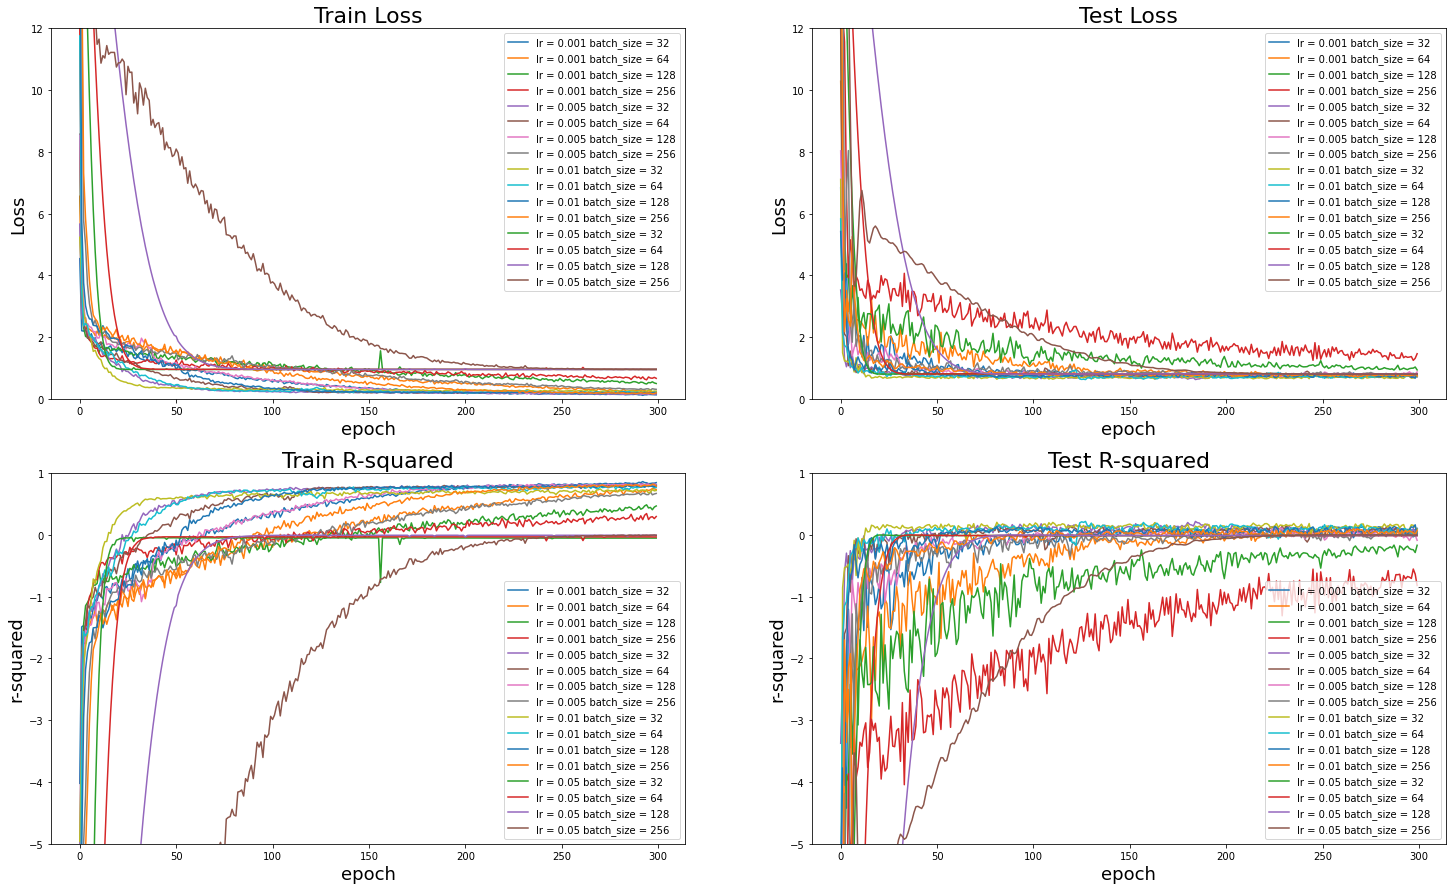

<Figure size 1800x1080 with 0 Axes>

In [36]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 12])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 12])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-5,1])

plt.show()

In [32]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.8464192223849947
0.7210039581124148
0.47551403990417257
0.16959696679307687
0.7618987074285847
0.8144254855018739
0.8404840617052738
0.7410653698494442
0.7539873089474538
0.766823226099819
0.7309001519452679
0.75938864833821
-0.05112233296756628
-0.03136220506093075
-0.005372152024185506
-0.00047378734690912695
___________________

0.037843808174654714
0.05011318040903623
-0.14875623505811264
-0.6959829531288684
0.07790593507828925
0.053240269939478946
0.023347402290396335
-0.027423935539474087
0.10715256489300973
0.09409109826825302
0.11618145641200273
0.04419270981384604
-0.00713154224126944
-0.010205732553889124
-0.009189089597607447
-0.00846811447855167
___________________

0.13504221347662118
0.2603893786668777
0.4949266999959946
0.7899538397789001
0.21373586012766913
0.17299386933445932
0.15155853629112243
0.24692133367061614
0.21897541425931147
0.21298020519316196
0.25551499873399736
0.22865677773952484
0.9608064316786252
0.9602250218391418
0.9561543881893158
0.954551625251770

### 2 best models

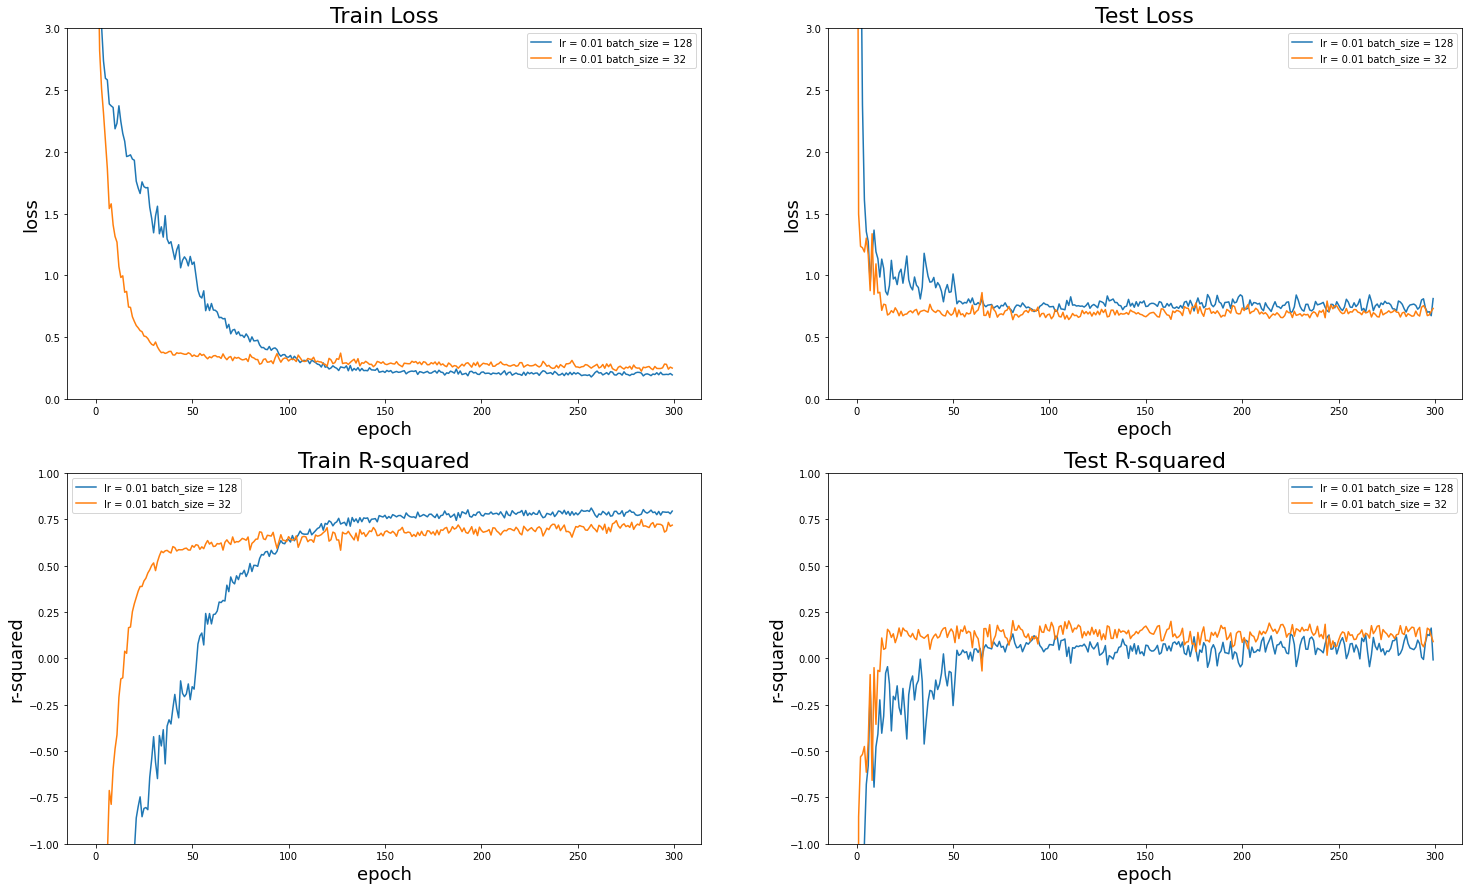

<Figure size 432x288 with 0 Axes>

In [39]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[10],label="lr = 0.01 batch_size = 128")
ax1.plot(train_losses_all[8],label="lr = 0.01 batch_size = 32")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[10],label="lr = 0.01 batch_size = 128")
ax2.plot(test_losses_all[8],label="lr = 0.01 batch_size = 32")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[10],label="lr = 0.01 batch_size = 128")
ax3.plot(train_accs_all[8],label="lr = 0.01 batch_size = 32")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1, 1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[10],label="lr = 0.01 batch_size = 128")
ax4.plot(test_accs_all[8],label="lr = 0.01 batch_size = 32")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1, 1])
plt.show()

## 4.2. Training

In [40]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=353, shuffle=False)

In [41]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/solubility_klek_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 5.14085726208157, Accuracy: -4.768363803903877
Test Avg. loss: 1.231157898902893, Accuracy: -0.3449305041948605
################## EPOCH 2 ##################
Train Avg. loss: 3.194791536860996, Accuracy: -2.564664073901046
Test Avg. loss: 4.100619792938232, Accuracy: -3.4795625932060243
################## EPOCH 3 ##################
Train Avg. loss: 2.878658395343357, Accuracy: -2.233607830344739
Test Avg. loss: 1.1122984886169434, Accuracy: -0.21508715750172946
################## EPOCH 4 ##################
Train Avg. loss: 2.344733315043979, Accuracy: -1.6457394953172417
Test Avg. loss: 2.1619207859039307, Accuracy: -1.3617064428189845
################## EPOCH 5 ##################
Train Avg. loss: 2.1247106075286863, Accuracy: -1.4269518941278898
Test Avg. loss: 1.364551305770874, Accuracy: -0.49065097078214337
################## EPOCH 6 ##################
Train Avg. loss: 2.157369515630934, Accuracy: -1.452160058935631
Tes

Train Avg. loss: 0.4873076323005888, Accuracy: 0.4484400732944026
Test Avg. loss: 0.7344825267791748, Accuracy: 0.1976431508305394
################## EPOCH 48 ##################
Train Avg. loss: 0.50395993689696, Accuracy: 0.44543318366680784
Test Avg. loss: 0.7188233137130737, Accuracy: 0.21474943328971996
################## EPOCH 49 ##################
Train Avg. loss: 0.49317001435491775, Accuracy: 0.44506925049602963
Test Avg. loss: 0.7292323112487793, Accuracy: 0.2033786239131491
################## EPOCH 50 ##################
Train Avg. loss: 0.36875314546955956, Accuracy: 0.582586443936292
Test Avg. loss: 0.7211427092552185, Accuracy: 0.21221573583329034
################## EPOCH 51 ##################
Train Avg. loss: 0.3862318519088957, Accuracy: 0.5649933228687397
Test Avg. loss: 0.7548655271530151, Accuracy: 0.17537657839981668
################## EPOCH 52 ##################
Train Avg. loss: 0.4498005015982522, Accuracy: 0.4905190715189838
Test Avg. loss: 0.7239522337913513, Accu

Train Avg. loss: 0.3799753530157937, Accuracy: 0.5689316986129798
Test Avg. loss: 0.7377429604530334, Accuracy: 0.19408145902560936
################## EPOCH 94 ##################
Train Avg. loss: 0.37520503799120586, Accuracy: 0.5755573744371334
Test Avg. loss: 0.7433066368103027, Accuracy: 0.18800364981510853
################## EPOCH 95 ##################
Train Avg. loss: 0.3438769085539712, Accuracy: 0.6086120885503408
Test Avg. loss: 0.7338885068893433, Accuracy: 0.19829202554264302
################## EPOCH 96 ##################
Train Avg. loss: 0.399279867278205, Accuracy: 0.5507236766861765
Test Avg. loss: 0.7458523511886597, Accuracy: 0.1852226537464382
################## EPOCH 97 ##################
Train Avg. loss: 0.3642144305838479, Accuracy: 0.5863206411698481
Test Avg. loss: 0.7852171063423157, Accuracy: 0.14222019261372687
################## EPOCH 98 ##################
Train Avg. loss: 0.4536459234025743, Accuracy: 0.49412018927222556
Test Avg. loss: 0.7545881867408752, Acc

Train Avg. loss: 0.3846447014146381, Accuracy: 0.5754889181520069
Test Avg. loss: 0.7426707744598389, Accuracy: 0.18869830965744794
################## EPOCH 140 ##################
Train Avg. loss: 0.3318625253935655, Accuracy: 0.6232992000146077
Test Avg. loss: 0.7435622215270996, Accuracy: 0.18772436253745794
################## EPOCH 141 ##################
Train Avg. loss: 0.3559156303604444, Accuracy: 0.5963413483185896
Test Avg. loss: 0.7765713930130005, Accuracy: 0.15166477828266278
################## EPOCH 142 ##################
Train Avg. loss: 0.3434676256444719, Accuracy: 0.6149804731978828
Test Avg. loss: 0.724556565284729, Accuracy: 0.20848637566475303
################## EPOCH 143 ##################
Train Avg. loss: 0.32548742476436826, Accuracy: 0.6294146176186388
Test Avg. loss: 0.8000540137290955, Accuracy: 0.1260121204080975
################## EPOCH 144 ##################
Train Avg. loss: 0.32037377953529356, Accuracy: 0.6368947119438783
Test Avg. loss: 0.7334566712379456

Train Avg. loss: 0.32471076432201595, Accuracy: 0.6311151706291505
Test Avg. loss: 0.8064248561859131, Accuracy: 0.11905252985267234
################## EPOCH 186 ##################
Train Avg. loss: 0.39635824528005387, Accuracy: 0.5662281839969666
Test Avg. loss: 0.7606136798858643, Accuracy: 0.16909711278728623
################## EPOCH 187 ##################
Train Avg. loss: 0.4008715483877394, Accuracy: 0.5616029490375118
Test Avg. loss: 0.7653242945671082, Accuracy: 0.16395120558842913
################## EPOCH 188 ##################
Train Avg. loss: 0.3550343970457713, Accuracy: 0.5994624777544046
Test Avg. loss: 0.8136258721351624, Accuracy: 0.11118610188321654
################## EPOCH 189 ##################
Train Avg. loss: 0.33353771037525604, Accuracy: 0.6258421193664555
Test Avg. loss: 0.7665141224861145, Accuracy: 0.16265146313618617
################## EPOCH 190 ##################
Train Avg. loss: 0.3643092953496509, Accuracy: 0.5919013414168635
Test Avg. loss: 0.7993156909942

Train Avg. loss: 0.4008390847179625, Accuracy: 0.555805984980087
Test Avg. loss: 0.7343108654022217, Accuracy: 0.1978307732731266
################## EPOCH 232 ##################
Train Avg. loss: 0.3753347976340188, Accuracy: 0.5822315672360322
Test Avg. loss: 0.730534553527832, Accuracy: 0.20195600146043147
################## EPOCH 233 ##################
Train Avg. loss: 0.39650740259223516, Accuracy: 0.5575469307985622
Test Avg. loss: 0.7368554472923279, Accuracy: 0.19505095878172096
################## EPOCH 234 ##################
Train Avg. loss: 0.3996057063341141, Accuracy: 0.5573423295236969
Test Avg. loss: 0.7488929033279419, Accuracy: 0.181901133025284
################## EPOCH 235 ##################
Train Avg. loss: 0.3623640023999744, Accuracy: 0.6040182533920715
Test Avg. loss: 0.7214797139167786, Accuracy: 0.21184752106927462
################## EPOCH 236 ##################
Train Avg. loss: 0.3993076632420222, Accuracy: 0.559120134895498
Test Avg. loss: 0.712780773639679, Accu

Train Avg. loss: 0.365818186601003, Accuracy: 0.5946516857292039
Test Avg. loss: 0.7667986750602722, Accuracy: 0.16234067460966373
################## EPOCH 278 ##################
Train Avg. loss: 0.37284812066290113, Accuracy: 0.5938757111573981
Test Avg. loss: 0.7646157741546631, Accuracy: 0.16472522672070866
################## EPOCH 279 ##################
Train Avg. loss: 0.31378377560112214, Accuracy: 0.6472929586495303
Test Avg. loss: 0.7651083469390869, Accuracy: 0.16418715304312226
################## EPOCH 280 ##################
Train Avg. loss: 0.3384188327524397, Accuracy: 0.6212084728798886
Test Avg. loss: 0.7926509380340576, Accuracy: 0.13409924886703817
################## EPOCH 281 ##################
Train Avg. loss: 0.34652026262548236, Accuracy: 0.6220071234013641
Test Avg. loss: 0.8014737367630005, Accuracy: 0.12446119425881652
################## EPOCH 282 ##################
Train Avg. loss: 0.33514094495524965, Accuracy: 0.6209326595410801
Test Avg. loss: 0.7642474770545

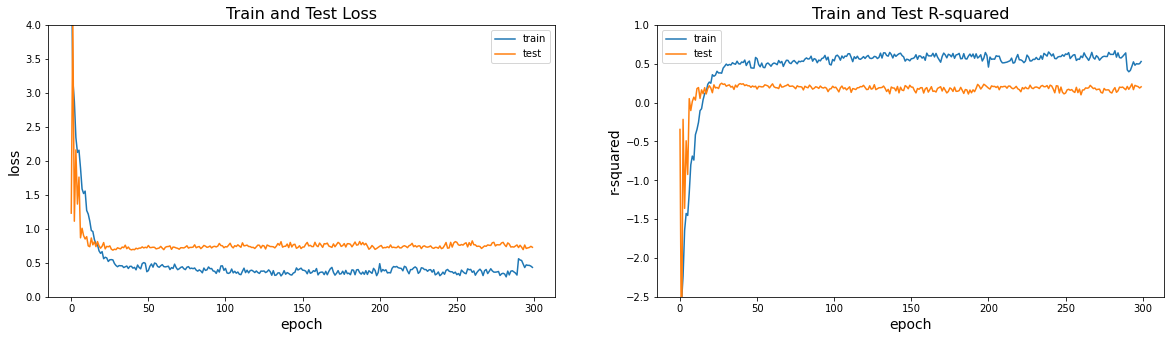

<Figure size 1440x360 with 0 Axes>

In [42]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,4])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-2.5,1])
ax2.legend()
plt.show()

In [43]:
model = FCNN()
model.load_state_dict(torch.load('../../models/solubility_klek_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.6745622
MSE: 0.68649584
RMSE: 0.82855046
R2 Square 0.2500643192063722 

